In [1]:
# Required by PythonicDISORT
import numpy as np
import scipy as sc
from numpy.polynomial.legendre import Legendre
from math import pi
from scipy import integrate

In [2]:
# Only required in this notebook for tests and exposition
import autograd as ag
import autograd.numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import constants

# Table of Contents
* [1. USER INPUT REQUIRED: Choose parameters](#1.-USER-INPUT-REQUIRED:-Choose-parameters)
	* [1.1 Choose optical properties](#1.1-Choose-optical-properties)
	* [1.2 Choose computational parameters](#1.2-Choose-computational-parameters)
	* [1.3 Choose phase function](#1.3-Choose-phase-function)
		* [1.3.1 OPTIONAL: Choose delta-M scaling](#1.3.1-OPTIONAL:-Choose-delta-M-scaling)
	* [1.4 Choose direct beam source](#1.4-Choose-direct-beam-source)
	* [1.5 OPTIONAL: Choose Dirichlet BCs](#1.5-OPTIONAL:-Choose-Dirichlet-BCs)
	* [1.6 OPTIONAL: Choose BDRF](#1.6-OPTIONAL:-Choose-BDRF)
	* [1.7 OPTIONAL: Choose isotrophic internal sources](#1.7-OPTIONAL:-Choose-isotrophic-internal-sources)
* [2. PythonicDISORT modules and outputs](#2.-PythonicDISORT-modules-and-outputs)
* [3. Breakdown of single layer solver](#3.-Breakdown-of-single-layer-solver)
	* [3.1 Quadrature](#3.1-Quadrature)
		* [3.1.1 Verification of quadrature](#3.1.1-Verification-of-quadrature)
		* [3.1.2 Normalization verification of phase function](#3.1.2-Normalization-verification-of-phase-function)
	* [3.2 Fourier expansion of solution](#3.2-Fourier-expansion-of-solution)
		* [3.2.1 Surface reflection](#3.2.1-Surface-reflection)
		* [3.2.2 Important terms](#3.2.2-Important-terms)
	* [3.3 Delta-M scaling](#3.3-Delta-M-scaling)
		* [3.3.1 Scaling a multi-layer atmosphere](#3.3.1-Scaling-a-multi-layer-atmosphere)
	* [3.4 System of ODEs](#3.4-System-of-ODEs)
		* [3.4.1 How to choose computational parameters](#3.4.1-How-to-choose-computational-parameters)
		* [3.4.2 Assembly of system](#3.4.2-Assembly-of-system)
	* [3.5 Diagonalization of coefficient matrix](#3.5-Diagonalization-of-coefficient-matrix)
	* [3.6 General solution for each mode and layer](#3.6-General-solution-for-each-mode-and-layer)
		* [3.6.1 The particular solutions](#3.6.1-The-particular-solutions)
		* [3.6.2 The homogeneous solution](#3.6.2-The-homogeneous-solution)
		* [3.6.3 Verification of the general solution](#3.6.3-Verification-of-the-general-solution)
	* [3.7 The full solution](#3.7-The-full-solution)
		* [3.7.1 Verification and visualization: uncorrected](#3.7.1-Verification-and-visualization:-uncorrected)
		* [3.7.2 NT corrections](#3.7.2-NT-corrections)
		* [3.7.3 Verification and visualization: NT corrected](#3.7.3-Verification-and-visualization:-NT-corrected)
	* [3.8 Computation of flux](#3.8-Computation-of-flux)
		* [3.8.1 Impact of delta-M scaling on flux calculations](#3.8.1-Impact-of-delta-M-scaling-on-flux-calculations)
		* [3.8.2 Verification of flux](#3.8.2-Verification-of-flux)
		* [3.8.3 Reflectance and transmittance](#3.8.3-Reflectance-and-transmittance)
* [4. Solve for multiple layers](#4.-Solve-for-multiple-layers)
	* [4.1 Memory inefficiencies](#4.1-Memory-inefficiencies)
	* [4.2 Verification of multi-layer solver](#4.2-Verification-of-multi-layer-solver)
* [5. Timing PythonicDISORT](#5.-Timing-PythonicDISORT)
* [6. Comparisons with Stamnes' DISORT](#6.-Comparisons-with-Stamnes'-DISORT)
	* [6.1 PyTest](#6.1-PyTest)
	* [6.2 Timing Stamnes' DISORT](#6.2-Timing-Stamnes'-DISORT)


Denote the optical depth as $\tau$, the cosine of the polar angle as $\mu$ (positive is upward), and the azimuthal angle as $\phi$ (positive is counterclockwise when looking down on the atmospheric layer). We wish to solve the (time-independent and one-dimensional) Radiative Transfer Equation

$$
\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = u(\tau, \mu, \phi) &-\frac{\omega}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right) - s(\tau)
\end{aligned}
$$

for the **diffuse** (specific) intensity, $u = u_\text{diffuse}$. This will be done numerically using the Discrete Ordinates Method. Our Discrete Ordinates Method package is called PythonicDISORT. The total intensity is given by

$$u_\text{total} = u_\text{diffuse} + u_\text{direct}$$

where for $-\mu_0 < 0$ (downwards),

$$
\begin{aligned}
&\mu\frac{\partial u_\text{direct}(\tau, \mu, \phi)}{\partial\tau} = u_\text{direct}(\tau, \mu, \phi), \quad u_\text{direct}(0, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \\
&\implies u_\text{direct}(\tau, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}
$$

The fundamental idea behind the Discrete Ordinates Method, from Chandrasekhar [[1]](#cite-Cha1960), is to perform the following series expansions

$$
\begin{aligned}
u\left(\tau, \mu, \phi\right) &\approx \sum_{n=0}^\text{NLoops} u^n\left(\tau, \mu\right)\cos\left(n\left(\phi_0 - \phi\right)\right) \quad \text{(Fourier cosine series expansion)}\\
p\left(\mu, \phi ; \mu', \phi'\right) = p\left(\cos\gamma\right) &\approx \sum_{\ell=0}^\text{NLeg} (2\ell + 1) g_\ell P_\ell\left(\cos\gamma\right) \quad \text{(Legendre series expansion)}
\end{aligned}
$$

which will deal with the $\phi'$ integral, and approximate the $\mu'$ integral using Gauss-Legendre quadrature with $\text{NQuad} = 2N$ quadrature points, i.e.

$$\int_{-1}^1 [\dots] \ \mathrm{d}\mu' \approx \sum_{|j|=1}^\text{N} [\dots]$$

**Multiple atmospheric layers**

It is mathematically straightforward to generalize to multiple atmospheric layers, each demarcated by $\tau_l$ for index $l = 0, 1, \dots, L$, and each with its own single-scattering albedo $\omega$ and phase function $p$. Each layer is modeled by its own radiative transfer equation, and until section [3.6](#3.6-General-solution-for-each-mode-and-layer) the method is the same for each layer. The only complication from moving to a multi-layered atmosphere is that the boundary conditions for each layer are coupled. Consequently, we would need to implement section [4](#4.-Solve-for-multiple-layers) instead of section [3.6](#3.6-General-solution-for-each-mode-and-layer).

# 1. USER INPUT REQUIRED: Choose parameters

Our notations somewhat follow those in Stamnes et. al.'s 1988 paper [[2]](#cite-STWJ1988), **with the equivalent variable, if available, in their FORTRAN DISORT code [[3]](#cite-Sta1999) in brackets**. The default values provided correspond to *Test Problem 3b: Henyey-Greenstein Scattering* of Stamnes' DISORT but with $(\mu_0, \phi_0)$ changed from $\left(1, 0\right)$ to $(0.6, 0.9 \pi)$ for better plots, and $\omega$ changed from $1$ to $0.9$ because we have not implemented the special case for $\omega = 1$.

## 1.1 Choose optical properties

The phase function will be chosen later in section [1.3](#1.3-Choose-phase-function). The solver function is `pydisort`, see section [2](#2.-PythonicDISORT-modules-and-outputs).

* **Optical depth (DTAUC denotes the optical thickness of each layer)**

We take the top of the atmosphere to have $\tau = 0$. Consequently, the first (zeroth index) atmospheric layer from the top has optical thickness $\tau_0$ and each subsequent layer $l$ has optical thickness $\tau_l - \tau_{l-1}$. The number of layers $\text{NLayers}$ (denoted $\text{NLYR}$ in Stamnes' DISORT [[3]](#cite-Sta1999)) is taken to be `len(tau_arr)`. We can accomodate large thickness using Stamnes-Conklin's substitutions [[4]](#cite-SC1984), though there will still be inaccuracies. We require each $\tau_l$ and the optical thickness of each layer to be positive.

In [3]:
# While we specify four atmospheric layers for illustrative purposes, the two layers
# have identical optical properties, and so this model is equivalent to a one layer model

#################### SUPPLIED TO PYDISORT ########################

tau_arr = np.array([2, 4, 6, 8])

##################################################################

In [4]:
# Used internally in PythonicDISORT
NLayers = len(tau_arr)

* **Single-scattering albedo (SSALB)**

As before, **the zeroth index corresponds to the layer at the top of the atmosphere**. Within each layer we assume $\omega$ to be independent from $\tau$. We require each $\omega \in [0,1)$, and values too close to $1$ will cause instability.

In [5]:
#################### SUPPLIED TO PYDISORT ########################

omega_arr = np.full(NLayers, 0.9)

##################################################################

## 1.2 Choose computational parameters

* **Number of quadrature points for the** $\mu'$ **integral (NSTR)**

This parameter is also known as the number of "streams" in the radiation literature and in Stamnes' DISORT [[3]](#cite-Sta1999). We require $\text{NQuad}$ to be $\geq 2$ and even. Note that this parameter contributes most to the computational complexity with scaling like $\mathcal{O}\left(\text{NQuad}^3\right)$.

In [6]:
#################### SUPPLIED TO PYDISORT ########################

NQuad = 16

##################################################################

We define $N = \text{NQuad} \ / \ 2$. This variable will be used extensively.

In [7]:
N = NQuad // 2

* **(OPTIONAL) Number of phase function Legendre coefficients to use (NMOM)**

We require $\text{NLeg} \leq \text{NQuad}$. In general we recommend choosing `NLeg = NQuad`. This is the default, and the only option Stamnes' DISORT [[3]](#cite-Sta1999) allows. See section [3.4.1](#3.4.1-How-to-choose-computational-parameters) for an explanation of the requirement.

In [8]:
#################### SUPPLIED TO PYDISORT ########################

NLeg = NQuad

##################################################################

* **(OPTIONAL) Number of loops, also number of Fourier modes to use in the numerical solution**

The number of loops must be positive and cannot exceed the number of phase function Legendre coefficients ($\text{NLeg}$). The default is `NLoops = NQuad`. See section [3.4.1](#3.4.1-How-to-choose-computational-parameters) for an explanation of this parameter and how it is adaptive in Stamnes' DISORT [[3]](#cite-Sta1999). Note that `only_flux = True` overwrites this parameter and is equivalent to `NLoops = 1`, except that `only_flux = True` will also cause the intensity function to not be returned. 

In [9]:
#################### SUPPLIED TO PYDISORT ########################

NLoops = NQuad # Maximum NLoops

##################################################################

* **(OPTIONAL) Whether to only compute the flux, or compute both flux and intensity (ONLYFL)**

If `only_flux = True`, PythonicDISORT will be much faster because we will only need to solve the $0$th Fourier mode integro-differential equation, see section [3.8](#3.8-Computation-of-flux).

In [10]:
#################### SUPPLIED TO PYDISORT ########################

only_flux = False

##################################################################

* **(OPTIONAL) Threshold for a sparse matrix framework**

When there are many atmospheric layers, the matrix used in solving for the coefficients of the homogenous solution is sparse and so we will use a sparse matrix framework, see section [4](#4.-Solve-for-multiple-layers). The check for whether to use SciPy's sparse matrix framework is `NLayers >= use_sparse_NLayers`. The default is `6`.

In [11]:
#################### SUPPLIED TO PYDISORT ########################

use_sparse_NLayers = 6

##################################################################

## 1.3 Choose phase function

We assume that the phase function is directly dependent on only the scattering angle $\gamma$, i.e. the scattering medium has spherical symmetry. Then, we can follow the method in [[2]](#cite-STWJ1988), but with slightly different notations and definitions, and expand the phase function in a Legendre series with respect to $\cos\gamma$:

$$
p(\cos\gamma) \approx \sum_{\ell=0}^\text{NLeg} (2\ell + 1)g_\ell P_\ell(\cos\gamma), \quad g_\ell = \frac{1}{2}\int_{-1}^{1} p(\cos\gamma) P_\ell(\cos\gamma) \mathrm{d}\cos\gamma
$$

The scattering angle $\gamma$ is between the incident angular vector $\left(\theta', \phi'\right)$ and the outgoing angular vector $(\theta, \phi)$ such that

$$
\begin{aligned}
\cos\gamma &= \cos\theta'\cos\theta + \sin\theta'\sin\theta\cos\left(\phi'-\phi\right) \\
\iff \nu &= \mu' \mu + \sqrt{1 - \mu'^2} \sqrt{1 - \mu^2} \cos\left(\phi'-\phi\right)
\end{aligned}
$$

where we define

$$
\nu = \cos\gamma, \quad \mu = \cos\theta, \quad\mu' = \cos\theta'
$$

Therefore, by the addition theorem for spherical harmonics

$$
P_\ell(\nu) = P_\ell\left(\mu'\right)P_\ell(\mu) + 2\sum_{m=1}^\ell \frac{(\ell-m)!}{(\ell+m)!}P_\ell^m\left(\mu'\right)P_\ell^m(\mu)\cos\left(m\left(\phi'-\phi\right)\right)
$$

In general, we will use the $\nu$-argument form in PythonicDISORT as it is the most straightforward to integrate. In our exposition, however, we will generally express a phase function with arguments $\mu, \phi, \mu', \phi'$ for consistency with the radiative transfer equation.

***Henyey-Greenstein phase function***

This definition excludes $\omega$ and is normalized to $1$,

$$p(\nu) = \frac{1-g^2}{\left(1+g^2-2 g \nu\right)^{3 / 2}}$$

In [12]:
p_HG_nu = lambda nu: (1 - g**2) / (1 + g**2 - 2 * g * nu) ** (3 / 2)

In [13]:
def p_HG_muphi(mu, phi, mu_p, phi_p):
    nu = PythonicDISORT.subroutines.calculate_nu(mu, phi, mu_p, phi_p)
    return p_HG_nu(nu)

**Asymmetry factor (GG)**

The magnitude of $g$ must be less than $1$. Magnitudes close to $1$ will cause instability.

In [14]:
g = 0.75

* **Unweighted phase function Legendre coefficients** $g_\ell$ **(PMOM)**

In [15]:
# Internal variable in PythonicDISORT
NLeg_all = 32

We encourage having `Leg_coeffs_all` contain as many phase function Legendre coefficients as are available. For most part PythonicDISORT will only use $\text{NLeg}$ coefficients, but the remaining coefficients are important for approximating the true phase function as accurately as possible for NT corrections, see section [3.7.2](#3.7.2-NT-corrections). We require at least $\text{NLeg}$ coefficients each with magnitude $<= 1$. For a multi-layer atmosphere, `Leg_coeffs_all` must be a matrix which $l$th row index corresponds to the atmospheric layer indexed by $l$.

In [16]:
#################### SUPPLIED TO PYDISORT ########################

Leg_coeffs_all = np.tile(g ** np.arange(NLeg_all), (NLayers, 1))

##################################################################

# Used internally in PythonicDISORT
Leg_coeffs = Leg_coeffs_all[:, :NLeg]

***Rayleigh phase function (currently unused)***

$$p(\nu) = \frac{3}{4} (1 + \nu^2)$$

In [17]:
p_R_nu = lambda nu: (3 / 4) * (1 + nu**2)  # Currently unused

**Integral derivation of Legendre coefficients for verification**

The following algorithm can be used to derive the Legendre coefficients for a general phase function. The algorithm can also be vectorized, but we would no longer be able to use `scipy.integrate.quad` for integration.

In [18]:
Leg_coeffs_test = np.empty(NLeg)
for ell in range(NLeg):
    integrand = lambda nu: p_HG_nu(nu) * sc.special.eval_legendre(ell, nu)
    Leg_coeffs_test[ell] = (1 / 2) * integrate.quad(integrand, -1, 1)[0]

assert np.allclose(Leg_coeffs[-1, :], Leg_coeffs_test)

print("Passed all tests")

Passed all tests


### 1.3.1 OPTIONAL: Choose delta-M scaling

Standard Legendre series approximation of highly anisotropic phase functions require a large number of terms to accurately capture the strong directional scattering. This is due to the slow decay of their Legendre coefficients. Using the HG phase function as an illustrative example, its Legendre coefficients are given by $\mathscr{g}_\ell = g^\ell$ where $g$ is the asymmetry factor. It is clear therefore that the closer $|g|$ is to $1$, i.e. the more anisotropic the HG phase function is, the slower its Legendre coefficients will decay.

We can use fewer Legendre terms if we re-express the phase function as a linear combination of a Dirac $\delta$-function and a more isotropic remainder. We follow the method in [[6]](#cite-Wis1977) for scaling the first $2M$ Legendre coefficients of a phase function such that they become the coefficients of the remainder.

$$
\begin{aligned}
&p(\nu) \approx 2 f \delta(1-\nu) + (1 - f) \sum_{\ell=0}^{2 M-1} (2\ell + 1) g_\ell^* P_\ell(\nu), \quad g^*_\ell = \frac{g_\ell - f}{1 - f} \\
&\iff p(\mu, \phi; \mu', \phi') \approx 4 \pi f \delta(\mu - \mu')\delta(\phi - \phi') + (1 - f) p^*(\mu, \phi; \mu', \phi')
\end{aligned}
$$

where the fractional scattering into peak $f \in [0, 1]$ is to be chosen, with $f = 0$ equivalent to no $\delta-M$ scaling. The method is equivalent to approximating the truncated coefficients as $f$ instead of $0$ as in standard truncation approximation. The first $2M$ Legendre coefficients of this re-expression will agree with those of the phase function.

We generally choose $f = g_{2M} = g_\text{NLeg}$ so that the first $2M + 1$, and not just $2M$, Legendre coefficients of the re-expression agree with those of the phase function. This is automatically done in Stamnes' DISORT [[3]](#cite-Sta1999). This choice of $f$ with $M = 1$ is equivalent to the delta-Eddington method, see [[7]](#cite-JWW1976). We will discuss the impact of this phase function re-expression on the radiative transfer equation in section [3.3](#3.3-Delta-M-scaling).

* **(OPTIONAL) Fractional scattering into peak parameter (Automatically chosen in Stamnes' DISORT [[3]](#cite-Sta1999))**

We require $f \in [0, 1)$. Values close to $1$ will cause instability. The zeroth entry of the array corresponds to the zeroth (topmost) atmospheric layer.

In [19]:
#################### SUPPLIED TO PYDISORT ########################

f_arr = np.full(NLayers, Leg_coeffs_all[0, NLeg])

##################################################################

* **(OPTIONAL) Whether to perform Nakajima-Tanaka intensity corrections, see section [3.7.2](#3.7.2-NT-corrections) (Always true in Stamnes' DISORT [[3]](#cite-Sta1999))**

In [20]:
#################### SUPPLIED TO PYDISORT ########################

NT_cor = False

##################################################################

## 1.4 Choose direct beam source

* **Parameters for the (incident) direct collimated (sun) beam**

We do not allow $\mu_0$ to coincide with a quadrature angle to prevent singularities. If that happens either $\text{NQuad}$ or $\mu_0$ should be tweaked. In the future this can be implemented as a special case. In addition, we do not allow $\mu_0 \leq 0$. Small $\mu_0$ values will cause instability. We require both angles to be principal and $I_0 \geq 0$. Choosing $I_0 = 0$ will disable this source and isotrophic internal sources can be chosen in section [1.7](#1.7-OPTIONAL:-Choose-isotrophic-internal-sources). The flux contribution of this source is $I_0 \mu_0$.

In [21]:
#################### SUPPLIED TO PYDISORT ########################

# Cosine of polar angle (UMU0) -- MOST IMPORTANT
mu0 = 0.6
# Intensity (FBEAM) -- Simply a scale factor
I0 = pi / mu0
# Azimuthal angle (PHI0) -- No effect on fluxes
phi0 = 0.9 * pi

##################################################################

## 1.5 OPTIONAL: Choose Dirichlet BCs

 * **(OPTIONAL) Dirichlet boundary conditions (FISOT is similar to** $b^-,$ **also see IBCND)**

$$
u\left(\tau_{\text{BoA}}, \mu_i, \phi \right) = \sum_{m = 0}^{\text{NLoops}}b^+_{im}\cos(m(\phi_0 - \phi)), \quad u(0, -\mu_i, \phi) = \sum_{m = 0}^{\text{NLoops}}b^-_{im}\cos(m(\phi_0 - \phi))
$$

for $i = 1, \dots, N$, where $b^\pm$ are matrices to be specified and "BoA" stands for "Bottom of Atmosphere". We have $i$ and $m$ as the row and column indices respectively. We also allow each of $b^\pm$ to be a constant. The default is $b^+ = b^- = 0$ (homogeneous BCs).

If $u\left(\tau_{\text{BoA}}, \mu, \phi \right) = \psi^+(\mu, \phi)$ and $u\left(0, -\mu, \phi \right) = \psi^-(\mu, \phi)$, then $\psi^+$ and $\psi^-$ must first be discretized in $\mu$, following which $b^+_{im}$ and $b^-_{im}$ are the truncated Fourier coefficients of $\psi^+_i$ and $\psi^-_i$ respectively. Note that `PythonicDISORT.subroutines.Gauss_Legendre_quad(N)[0]` can be used to get the grid points $\mu_i$. We require $\psi^+$ and $\psi^-$ to be even about some $\phi$ value (not necessarily $\phi_0$) for them to be compatible with the pure cosine series expansion of the solution. Each BC input must be a matrix of dimension $N \times \text{NLeg}$ or a scalar. If the input is a scalar the BC will be taken to be isotropic radiation of that magnitude, e.g. `b_neg = 7` implies

$$b^-_{i0} = 7, \quad \forall i = 1, \dots, N, \qquad  b^-_{im} = 0, \quad \forall m = 1, \dots, \text{NLoops}, \forall i = 1, \dots, N$$

Note that `b_neg` with a scalar input is equivalent to the argument `FISOT` in Stamnes' DISORT [[3]](#cite-Sta1999).

In [22]:
#################### SUPPLIED TO PYDISORT ########################

# At bottom of atmosphere
b_pos = 1
# At top of atmosphere
b_neg = 1

##################################################################

# Code within pydisort to ensure that the BC inputs are of the correct shape
scalar_b_pos, scalar_b_neg = False, False
if len(np.atleast_1d(b_pos)) == 1:
    scalar_b_pos = True
else:
    assert np.shape(b_pos) == (N, NLoops)
    
if len(np.atleast_1d(b_neg)) == 1:
    scalar_b_neg = True
else:
    assert np.shape(b_neg) == (N, NLoops)

The BoA Dirichlet BC can be used to model longwave radiation from the surface.

## 1.6 OPTIONAL: Choose BDRF

In order to specify a reflective surface with Bi-Directional Reflectance Function (BDRF) $q$, specify its Legendre coefficients $h_\ell$ with respect to the cosine of the scattering angle $\nu$. For $0 < \mu, \mu' \leq 1$, we have

$$q(\mu, \phi; -\mu', \phi') = q(\nu) \approx \sum_{\ell=0}^\text{NBDRF} (2\ell + 1)h_\ell P_\ell(\nu), \quad h_\ell = \frac{1}{2}\int_{-1}^{1} q(\nu) P_\ell(\nu) \mathrm{d}\nu$$

This is analogous to our treatment of the phase function $p$, and we similarly assume $q$ to demonstrate spherical symmetry.

Note that

$$\frac{1}{\pi}\int_0^1 \int_0^{2\pi} \mu q(\mu, \phi; -\mu', \phi') \mathrm{d} \phi \mathrm{d} \mu = \omega_s$$

where $\omega_s$ is the albedo of the surface. It is the user's responsibility to ensure that $0 \leq \omega_s \leq 1$ in accordance with physical constraints.

***Lambertian BDRF***

$$q(\nu) = \omega_s$$

**Surface albedo (ALBEDO)**

In [23]:
omega_s = 0.1 # Ocean albedo is approximately 0.1

 * **(OPTIONAL) Unweighted BDRF Legendre coefficients (No direct equivalent in Stamnes' DISORT [[3]](#cite-Sta1999), but see variables *IBCND* and *LAMBER*)**
 
 We require the number of BDRF Legendre coefficients to be non-negative and $\leq \text{NLeg}$. The default is a black surface.

In [24]:
#################### SUPPLIED TO PYDISORT ########################

Leg_coeffs_BDRF = np.array([omega_s])

##################################################################

# Used internally in PythonicDISORT
NBDRF = len(Leg_coeffs_BDRF)

## 1.7 OPTIONAL: Choose isotrophic internal sources

For each atmospheric layer $l$,

$$s_l(\tau) = \mathscr{a}_{l0} + \mathscr{a}_{l1} \tau + \dots + \mathscr{a}_{ln} \tau^n$$

If $s_l$ is not a polynomial then the above should be a polynomial approximation of the true $s_l$. Note that continuity between layers is not required. The coefficient matrix $\mathscr{a}$ defaults to an empty matrix which means no isotrophic internal sources.

* **(OPTIONAL) Coefficient matrix** $\mathscr{a}$

**Example with parameters: Blackbody radiation**

Let $B$ denote the Planck function with SI units $W sr^{−1} m^{−2} m^{−1}$. We use

$$s_l(\tau) = \epsilon_l B_\lambda(T(\tau))$$

where the wavelength $\lambda$ is fixed across the entire atmosphere, and $\epsilon_l = 1 - \omega_l$ by Kirchoff's law. Following [[4, section 2.5]](#cite-STL2000), we make the assumption that

$$B_\lambda(T(\tau)) = a_0 + a_1 \tau$$

where $a_0, a_1$ are fixed across the entire atmosphere. We interpolate the points $\big(0, B(T(0))\big)$ and $\big(\tau_{\text{BoA}}, B(T(\tau_{\text{BoA}}))\big)$ to get
 
$$
\begin{aligned}
a_0 &= B(T(0)), \quad &&\ a_1 = \frac{B(T(\tau_{\text{BoA}})) - B(T(0))}{\tau_{\text{BoA}}} \\
\mathscr{a}_{l0} &= \epsilon_l a_0, \quad &&\mathscr{a}_{l1} = \epsilon_l a_1
\end{aligned}$$

In [25]:
#################### Parameters to choose ########################

wavelength = 10e-6
T_ToA = 220  # Temperature at Top of Atmosphere
T_BoA = 300  # Temperature at Bottom of Atmosphere

##################################################################

Planck = lambda T: (2 * sc.constants.h * sc.constants.c**2 / wavelength**5) / (
    np.exp(sc.constants.h * sc.constants.c / (wavelength * sc.constants.k * T)) - 1
)
emission_coeff = 1 - omega_arr  # By Kirchoff's law
tau_BoA = tau_arr[-1]
mathscr_a0 = Planck(T_ToA)
mathscr_a1 = (Planck(T_ToA) - Planck(T_BoA)) / tau_BoA

In [26]:
###################################### SUPPLIED TO PYDISORT #########################################

s_poly_coeffs = emission_coeff[:, None] * np.array([mathscr_a0, mathscr_a1])[None, :]

#####################################################################################################

# Used internally in PythonicDISORT
Nscoeffs = np.shape(s_poly_coeffs)[1]
n = Nscoeffs - 1

In [27]:
# Only used in tests
s = lambda tau: tau[:, None] ** np.arange(Nscoeffs)[None, :] @ s_poly_coeffs[0, :]

# 2. PythonicDISORT modules and outputs

The PythonicDISORT package has two public modules: `pydisort` and `subroutines`. The `pydisort` module contains a single eponymous function. The `subroutines` module contains miscellaneous functions that are called in `pydisort`. These functions can also be called directly, as will be done in section [3](#3.-Breakdown-of-single-layer-solver). Users may want to directly call three functions in particular: `Clenshaw_Curtis_quad` and `Gauss_Legendre_quad` generate the quadrature nodes and weights for $\mu$ integration from $0$ to $1$ and $\phi$ integration from $0$ to $2\pi$ respectively. The third function `generate_FD_mat` generates a sparse first derivative matrix with second-order accuracy. Both `Clenshaw_Curtis_quad` and `generate_FD_mat` are not called in `pydisort` but are used in our verification tests.

**The outputs of the** `pydisort` **function**

The solver function `pydisort` will always return `mu_arr` (type: array), `flux_up` (type: function) and `flux_down` (type: function). The first output `mu_arr` is the array of $\mu_i$ values, i.e. $\mu$ quadrature nodes. Both `flux_up` $(F^+)$ and `flux_down` $(F^-)$ accept only one argument, $\tau$, and return the diffuse fluxes at the specified optical depths in the upward and downward directions respectively. The latter also returns the direct flux as its second output. More details on the flux functions can be found in section [3.8](#3.8-Computation-of-flux). The distinction between "direct" and "diffuse" is explained in the preamble, above section [1](#1.-USER-INPUT-REQUIRED:-Choose-parameters). 

When `only_flux = False` (default), `pydisort` will also output the (diffuse specific) intensity function `u` $(u)$ which is continuous and variable in $\tau$ and $\phi$, which are its arguments, but discrete in $\mu$ and fixed to the quadrature points $\mu_i$. The function output is 3D and the $0, 1, 2$ axes capture $\mu, \tau, \phi$ variation respectively. The first half of the $\mu$ indices correspond to $u^+$ (upward) and the second half to $u^-$ (downward) in alignment with `mu_arr`. Finally, note the optional flag `return_Fourier_error` which defaults to `False`, see section [3.7](#3.7-The-full-solution) for more details.

We import our PythonicDISORT package

In [28]:
import PythonicDISORT

# 3. Breakdown of single layer solver

In this section we break down and explain the code for solving the radiative transfer equation for a single atmospheric layer. Unless otherwise stated, we will disable $\delta-M$ scaling (`f = 0`), NT corrections (`NT_cor = False`) and have no isotrophic internal sources (`s_poly_coeffs=np.array([[]])`). We will explain $\delta-M$ scaling and NT corrections in their independent subsections.

**Tensor product coding philosophy**

First, a foreword on our coding philosophy for tensor products. We will use the following methods in order of preference:

* Broadcasting: e.g. outer product of `array1` and `array2` is coded as `array1[:, None] * array2[None, :]`.
* NumPy function `einsum` with `optimize = True`: `np.einsum` uses Einstein's summation convention. The documentation can be found at https://numpy.org/doc/stable/reference/generated/numpy.einsum.html.

We believe that this is the best balance between code readability and speed. Other common NumPy functions for tensor products are `np.outer` and `np.tensordot` but we do not use them.

## 3.1 Quadrature

Generation of Double Gauss-Legendre quadrature weights and points to numerically integrate over $\mu$ from $-1$ to $1$

In [29]:
# For positive mu values (the weights are identical for both domains)
mu_arr_pos, W = PythonicDISORT.subroutines.Gauss_Legendre_quad(N) # mu_arr_neg = -mu_arr_pos
mu_arr = np.concatenate([mu_arr_pos, -mu_arr_pos])
full_weights_mu = np.concatenate([W, W])

### 3.1.1 Verification of quadrature

$$\int_{a}^{b} e^x \ \mathrm{d}x = e^b - e^a$$

In [30]:
# Double Gauss-Legendre quadrature; integrate from -1 to 1
true_sol = np.exp(1) - np.exp(-1)

print(
    "Gauss-Legendre quadrature error ratio =",
    np.abs((true_sol - np.sum(np.exp(mu_arr) * full_weights_mu)) / true_sol),
)

Gauss-Legendre quadrature error ratio = 0.0


In [31]:
# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1   

Generation of Clenshaw-Curtis quadrature weights and points to numerically integrate over $\phi$ from $0$ to $2\pi$; these will only be used in tests

In [32]:
# Clenshaw-Curtis quadrature; integrate from -1 to 1
phi_arr, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi)
true_sol = np.exp(2 * pi) - 1

print(
    "Clenshaw-Curtis quadrature error ratio =",
    np.abs((true_sol - np.sum(np.exp(phi_arr) * full_weights_phi)) / true_sol),
)

Clenshaw-Curtis quadrature error ratio = 2.1270086547936496e-16


### 3.1.2 Normalization verification of phase function

We expect that

$$
\frac{1}{4 \pi} \int_{-1}^1 \int_0^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) \mathrm{d} \phi \mathrm{d} \mu = 1
$$

In [33]:
def truncated_phase_func(mu, phi, mu_p, phi_p):
    nu = PythonicDISORT.subroutines.calculate_nu(mu, phi, mu_p, phi_p)
    return Legendre(Leg_coeffs[0, :])(nu)

In [34]:
phi_arr, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi)

normalize_p = np.einsum(
    "ijkl, i, j -> kl",
    truncated_phase_func(mu_arr, phi_arr, mu_arr, phi_arr),
    full_weights_mu,
    full_weights_phi,
    optimize=True,
) / (4 * pi)

print("Max pointwise error ratio =", np.max(np.abs(normalize_p - 1)))

Max pointwise error ratio = 1.9934995876269568e-09


This error hints at PythonicDISORT's errors and is a preliminary way to judge whether to increase or decrease $\text{NQuad}$ and $\text{NLeg}$.

## 3.2 Fourier expansion of solution

*We will re-derive equations (6a) to (6d) of [[2]](#cite-STWJ1988) in this subsection.*

We wish to turn the problem of solving the radiative transfer equation

$$
\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = u(\tau, \mu, \phi) &-\frac{\omega}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right) - s(\tau)
\end{aligned}
$$

into the problem of solving

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\tau, \mu, \mu'\right) u^m\left(\tau, \mu'\right) \mathrm{d} \mu' - Q^m(\tau, \mu) - \delta_{0m}s(\tau)
$$

for each Fourier mode $m$, where $\delta_{0m}$ is the Kronecker delta for indices $0$ and $m$.

**Definitions and expansions**

We have the definitions and expansions

$$
\begin{aligned}
u\left(\tau, \mu, \phi\right) &\approx \sum_{n=0}^\text{NLoops} u^n\left(\tau, \mu\right)\cos\left(n\left(\phi_0 - \phi\right)\right) \quad \text{(Fourier cosine series expansion)} \\
p\left(\mu, \phi ; \mu', \phi'\right) = p\left(\nu\right) &\approx \sum_{\ell=0}^\text{NLeg} \mathscr{g}_\ell P_\ell\left(\nu\right) \quad \text{(Legendre series expansion)}
\end{aligned}
$$
$$
\begin{aligned}
\mathscr{g}_\ell &= \frac{2\ell + 1}{2}\int_{-1}^{1} p\left(\nu\right) P_\ell\left(\nu\right) \mathrm{d}\nu, \quad &&\mathscr{g}_\ell^m = \frac{\left(\ell-m\right)!}{\left(\ell+m\right)!} \mathscr{g}_\ell
\end{aligned}
$$

where $\mathscr{g}_\ell$ are the *weighted* Legendre coefficients, $\mathscr{g}_\ell = (2 \ell + 1) g_\ell$. As elaborated upon in section [1.3](#1.3-Choose-phase-function),

$$
P_\ell\left(\nu\right) = P_\ell\left(\mu'\right)P_\ell\left(\mu\right) + 2\sum_{m=1}^\ell \frac{\left(\ell-m\right)!}{\left(\ell+m\right)!}P_\ell^m(\mu')P_\ell^m\left(\mu\right)\cos\left(m\left(\phi'-\phi\right)\right)
$$

Consequently, we can expand the $\mu, \phi, \mu', \phi'$ form of the phase function as

$$
p\left(\mu, \phi; \mu', \phi'\right) \approx \sum_{\ell=0}^\text{NLeg} \left[ \mathscr{g}_\ell P_\ell\left(\mu'\right)P_\ell\left(\mu\right) + 2\sum_{m=1}^\ell \mathscr{g}_\ell^m P_\ell^m(\mu')P_\ell^m\left(\mu\right)\cos\left(m\left(\phi'-\phi\right)\right) \right]
$$

Going forward we will omit the upper limit of a sum when it is irrelevant to reduce the clutter of our expressions.

**Multiple scattering term**

We first focus on the multiple scattering term of the radiative transfer equation. We substitute the expansions of $p(\mu, \phi; \mu', \phi')$ and $u(\tau, \mu, \phi)$ to get

$$
\begin{aligned}
&\frac{\omega}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&\approx \frac{\omega}{4 \pi} \int_{-1}^{1} \Bigg[ \int_{0}^{2 \pi} \sum_{n=0} \sum_{\ell=0} u^n(\tau) \mathscr{g}_\ell P_\ell\left(\mu'\right)P_\ell(\mu) \cos\left(n\left(\phi_0 - \phi'\right)\right) \\
&\quad+ 2\sum_{n=0} \sum_{\ell=0} \sum_{m=1}^\ell u^n(\tau) \mathscr{g}_\ell^m P_\ell^m(\mu')P_\ell^m(\mu)\cos\left(m\left(\phi'-\phi\right)\right) \cos\left(n\left(\phi_0 - \phi'\right)\right) \mathrm{d} \phi' \Bigg] \mathrm{d} \mu' \\
&= \frac{\omega}{4 \pi} \int_{-1}^{1} \Bigg[ \int_{0}^{2 \pi} \sum_{\ell=0} u^0(\tau) \mathscr{g}_\ell P_\ell\left(\mu'\right)P_\ell(\mu) \\
&\quad+ 2\sum_{n=1} \sum_{\ell=n} \sum_{m=1}^\ell u^n(\tau) \mathscr{g}_\ell^m P_\ell^m(\mu')P_\ell^m(\mu)\cos\left(m\left(\phi'-\phi\right)\right) \cos\left(n\left(\phi_0 - \phi'\right)\right) \mathrm{d} \phi' \Bigg] \mathrm{d} \mu' \\
&= \frac{\omega}{4 \pi} \int_{-1}^{1} \left[ 2\pi \sum_{\ell=0} u^0(\tau) \mathscr{g}_\ell P_\ell\left(\mu'\right)P_\ell(\mu) + 2\pi\sum_{n=1} \sum_{\ell=n} u^n(\tau) \mathscr{g}_\ell^n P_\ell^n(\mu')P_\ell^n(\mu)\cos\left(n\left(\phi_0 - \phi\right)\right) \right] \mathrm{d} \mu' \\
&= \sum_{m=0} \left\{ \int_{-1}^{1} \frac{\omega}{2} \sum_{\ell=m} u^m \mathscr{g}_\ell^m P_\ell^m(\mu')P_\ell^m(\mu) \mathrm{d} \mu'\right\} \cos\left(m\left(\phi_0 - \phi\right)\right)
\end{aligned}
$$

The term in the curly brackets of the last line is the contribution of the multiple scttering term to the $m$th Fourier mode of the radiative transfer equation.

**Sunbeam source term**

Next, we focus on the sunbeam source term; the isotrophic internal sources will only contribute to the $0$th Fourier mode as they have no $\phi$ dependence. Once again, we substitute the expansion of $p(\mu, \phi; \mu', \phi')$ to get

$$
\begin{aligned}
&\frac{\omega I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right) \approx \\
&\frac{\omega I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \left[ \sum_{\ell=0} \mathscr{g}_\ell P_\ell\left(-\mu_0\right)P_\ell(\mu) + 2\sum_{\ell=0}\sum_{m=1}^\ell \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right) \right]
\end{aligned}
$$

It is immediately apparent that the contribution to the $0$th moment is

$$
\frac{\omega I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right)\sum_{\ell=0} \mathscr{g}_\ell P_\ell\left(-\mu_0\right)P_\ell(\mu)
$$

For $n \geq 1$, to determine the contribution to the $n$th moment, we multiply by $\pi^{-1}\cos\left(n\left(\phi_0-\phi\right)\right)$ and integrate over $\phi$ from $0$ to $2\pi$ to get

$$
\begin{aligned}
&\frac{\omega I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \int_{0}^{2\pi} \frac{2}{\pi}\sum_{\ell=0}\sum_{m=1}^\ell \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right)\cos\left(n\left(\phi_0-\phi\right)\right) \mathrm{d}\phi \\
&= \frac{\omega I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \int_{0}^{2\pi} \frac{2}{\pi}\sum_{\ell=n}\sum_{m=1}^\ell \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right)\cos\left(n\left(\phi_0-\phi\right)\right) \mathrm{d}\phi \\
&= \frac{\omega I_0}{2 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \sum_{\ell=n} \mathscr{g}_\ell^n P_\ell^n\left(-\mu_0\right)P_\ell^n(\mu)
\end{aligned}
$$

Therefore, the contribution of the source term to the $m$th Fourier mode of the radiative transfer equation (we perform the change of variables $m = n$) is

$$
\frac{\omega I_0 (2 - \delta_{0m})}{4 \pi}\exp\left(-\mu_{0}^{-1} \tau\right)\sum_{\ell=m} \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)
$$

### 3.2.1 Surface reflection

We also address the surface reflection which is given by

$$
\begin{aligned}
&\frac{1}{\pi}\int_0^1 \int_0^{2\pi} \mu' \left(u(\tau, -\mu', \phi') + u_\text{direct}(\tau, -\mu', \phi')\right) q(\mu, \phi; -\mu', \phi')  \mathrm{d}\phi' \mathrm{d}\mu' \Bigg |_{\,\tau \,=\, \tau_\text{BoA}} \\
&= \frac{1}{\pi}\int_0^1 \int_0^{2\pi} \mu' \left(u(\tau_\text{BoA}, -\mu', \phi') + I_0 \delta(\mu_0 - \mu') \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)\right) q(\mu, \phi; -\mu', \phi')  \mathrm{d}\phi' \mathrm{d}\mu' \\
&= \frac{1}{\pi}\int_0^1 \int_0^{2\pi} \mu' u(\tau_\text{BoA}, -\mu', \phi') q(\mu, \phi; -\mu', \phi') \mathrm{d}\phi' \mathrm{d}\mu' + \frac{I_0 \mu_0}{\pi} \exp\left(-\mu_{0}^{-1} \tau\right) q(\mu, \phi; -\mu_0, \phi_0)
\end{aligned}
$$

We have the Legendre expansion of the BDRF from section [1.6](#1.6-OPTIONAL:-Choose-BDRF),

$$q(\mu, \phi; -\mu', \phi') = q(\nu) \approx \sum_{\ell=0}^\text{NLeg} (2\ell + 1)h_\ell P_\ell(\nu), \quad h_\ell = \frac{1}{2}\int_{-1}^{1} q(\nu) P_\ell(\nu) \mathrm{d}\nu$$

and so we can apply the same techniques as above to get

$$
\begin{aligned}
&\sum_{m=0} \Bigg\{\int_{0}^{1} 2\sum_{\ell=m} \mu' u^m(\tau_\text{BoA}) \mathscr{h}_\ell^m P_\ell^m(\mu')P_\ell^m(\mu)  \mathrm{d} \mu' \\ 
&+ \frac{ I_0 \mu_0 (2 - \delta_{0m})}{ \pi}\exp\left(-\mu_{0}^{-1} \tau_\text{BoA}\right)\sum_{\ell=m} \mathscr{h}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu) \Bigg\} \cos\left(m\left(\phi_0 - \phi\right)\right)
\end{aligned}
$$

where

$$\mathscr{h}_\ell^m = \frac{\left(\ell-m\right)!}{\left(\ell+m\right)!} (2\ell + 1) h$$

The term in the curly brackets of the last line is the contribution of the surface reflection to the $m$th Fourier mode of the radiative transfer equation.

### 3.2.2 Important terms

For each Fourier mode, $m \geq 0$, we have derived the integro-differential equation

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\mu, \mu'\right) u^m\left(\tau, \mu'\right) \mathrm{d} \mu' - Q^m(\tau, \mu) - \delta_{0m}s(\tau)
$$

where

$$
\begin{aligned}
D^m\left(\mu, \mu' \right) &= \frac{\omega}{2} \sum_{\ell=m}^\text{NLeg} \mathscr{g}_\ell^m P_\ell^m(\mu')P_\ell^m(\mu) \\
Q^m(\tau, \mu) &= X^m(\mu) \exp\left(-\mu_{0}^{-1} \tau\right) \\
X^m(\mu) &= \frac{\omega I_0 (2 - \delta_{0m})}{4 \pi}\sum_{\ell=m}^\text{NLeg} \mathscr{g}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)
\end{aligned}
$$

and our approach will be to solve for each $u^m$ then construct the full solution.

**Surface reflection terms**

Similarly, for each Fourier mode, $m \geq 0$, the surface reflection terms are

$$\int_0^1 \mu'\mathscr{D}^m(\mu, -\mu') u^m(\tau_\text{BoA}, -\mu') \mathrm{d}\mu' + \mathscr{X}^m(\mu)\exp\left(-\mu_{0}^{-1} \tau_\text{BoA}\right)$$

with the analogous definitions
$$
\begin{aligned}
\mathscr{D}^m(\mu, -\mu') &= 2\sum_{\ell=m}^\text{NLeg} \mathscr{h}_\ell^m P_\ell^m(-\mu')P_\ell^m(\mu) \\
\mathscr{X}^m(\mu) &= \frac{ I_0 \mu_0 (2 - \delta_{0m})}{ \pi}\sum_{\ell=m}^\text{NLeg} \mathscr{h}_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)
\end{aligned}
$$

## 3.3 Delta-M scaling

Continuing from section [1.3.1](#1.3.1-OPTIONAL:-Choose-delta-M-scaling), we substitute the truncated, $\delta-M$ approximated phase function

$$
p(\mu, \phi; \mu', \phi') = 4 \pi f \delta(\mu - \mu')\delta(\phi - \phi') + (1 - f) p^*(\mu, \phi; \mu', \phi')
$$

into the radiative transfer equation to get

\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = \ &(1 - \omega f) u(\tau, \mu, \phi) -\frac{(1 - f)\omega}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p^*\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\omega I_0 \left(f \delta(\mu - \mu_0)\delta(\phi - \phi_0) + \frac{1 - f}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right)\right) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}

Note that we omit the isotropic sources term $s$ as it is unaffected by $\delta-M$ scaling. We shift the $\delta$-function term to the direct beam to get

$$\mu\frac{\partial u_\text{direct}(\tau, \mu, \phi)}{\partial\tau} = (1 - \omega f)u_\text{direct}(\tau, \mu, \phi), \quad u_\text{direct}(0, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0)$$

We have added $\omega f$ of the direct beam that would originally be considered scattered back into the direct beam.

Denote the remaining diffuse intensity as $u^*$, and the augmented direct intensity as $u^*_\text{direct}$. Perform the change of variables

$$\tau^* = (1 - \omega f) \tau \iff \frac{\mathrm{d}\tau}{\mathrm{d}\tau^*} = \frac{1}{1 - \omega f}, 
\quad \omega^* = \frac{1-f}{1 - \omega f} \omega$$

to get

$$
\begin{aligned}
\mu \frac{\partial u^*(\tau^*, \mu, \phi)}{\partial \tau^*} = u^*(\tau^*, \mu, \phi) &-\frac{\omega^*}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p^*\left(\mu, \phi ; \mu', \phi'\right) u^*\left(\tau^*, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega^* I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)
\end{aligned}
$$
and
$$
\begin{aligned}
&\mu\frac{\partial u^*_\text{direct}(\tau^*, \mu, \phi)}{\partial\tau^*} = u^*_\text{direct}(\tau^*, \mu, \phi), \quad u^*_\text{direct}(0, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \\
&\implies u^*_\text{direct}(\tau^*, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau^*\right)
\end{aligned}
$$

This is exactly our starting problem, but with every $\tau$, $\omega$, $p$ swapped for $\tau^*$, $\omega^*$, $p^*$ respectively. In the literature, $\tau$, $\omega$, $p$ are described as having been $\delta-M$ scaled (or just "delta-scaled") to $\tau^*$, $\omega^*$, $p^*$. See [[6]](#cite-Wis1977) for more details on $\delta-M$ scaling.

### 3.3.1 Scaling a multi-layer atmosphere

When scaling a multi-layer atmosphere, we do not directly scale `tau_arr` for that will lead to discontinuity between each layer that has a different scale parameter $1 - \omega f$. Instead, we **scale the optical thickness** of each layer. Therefore, while $\tau_0^* = (1 - \omega_0 f_0)\tau_0$, in general $\tau_l^* \neq (1 - \omega_l f_l)\tau_l$.

In [35]:
# Example: Delta-M scaling of tau_arr
thickness_arr = np.concatenate([[tau_arr[0]], np.diff(tau_arr)])
scaled_thickness_arr = (1 - omega_arr * f_arr) * thickness_arr
# We include 0 in the array for computational reasons
scaled_tau_arr_with_0 = np.array(
    list(map(lambda l: np.sum(scaled_thickness_arr[:l]), range(NLayers + 1)))
)
print("Delta-M scaled `tau_arr` with 0 =", scaled_tau_arr_with_0)

Delta-M scaled `tau_arr` with 0 = [0.         1.98195933 3.96391866 5.94587798 7.92783731]


## 3.4 System of ODEs

*We will prove equations (7a) and (7b) of [[2]](#cite-STWJ1988) in this subsection.*

Continuing from section [3.2](#3.2-Fourier-expansion-of-solution), we aim to (approximately) solve the integro-differential equation

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\mu, \mu'\right) u^m\left(\tau, \mu'\right) \mathrm{d} \mu' - Q^m(\tau, \mu) - \delta_{0m}s(\tau)
$$

for each Fourier mode $m$. We accomplish this through discretization of the $\mu$ integral. We split the $\mu$ integral into two integrals: from $-1$ to $0$ and from $0$ to $1$ since there is a singularity at $\mu = 0$. We then approximate each integral by Gauss-Legendre quadrature. This is the *double-Gauss method* from [[8]](#cite-Syk1951).

By double-Gauss quadrature, we can approximate the integro-differential equation as


$$
\mu_i \frac{d u^m(\tau, \mu_i)}{d \tau}=u^m(\tau, \mu_i)-\sum_{|j| = 1}^N w_j D^m\left(\mu_i, \mu_j\right) u^m\left(\tau, \mu_j\right) - Q^m(\tau, \mu_i) - \delta_{0m}s(\tau)
$$

for $i = 1, \dots, N$, where $2N$ equals the number of quadrature points. We define

$$
\begin{aligned}
&\alpha = M^{-1}\left(D^{+} W - I\right) &&\beta = M^{-1} D^{-} W \\
&D^{+}[i,j] = D^m\left(\mu_i, \mu_j\right) = D^m\left(-\mu_i,-\mu_j\right) &&D^{-}[i,j] = D^m\left(-\mu_i, \mu_j\right) = D^m\left(\mu_i,-\mu_j\right) \\
&W[i,j] = w_i\delta_{ij} &&M[i,j] = \mu_i\delta_{ij} \\ 
&Q^{\pm}(\tau)[i] = Q^m\left(\tau, \pm \mu_i\right) &&u^\pm[i] = u^m(\pm \mu_i)
\end{aligned}
$$

and, omitting the $\tau$ argument, 

$$
\tilde{Q}^\pm = M^{-1} Q^\pm(\tau), \quad \tilde{\mathrm{S}} = M^{-1} s(\tau)
$$ 

We **claim** that the discretized equation for each Fourier mode can be re-expressed as the system of ODEs

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix} + \delta_{0m}\begin{bmatrix} -\tilde{\mathrm{S}} \\ \tilde{\mathrm{S}} \end{bmatrix}
$$

**Proof**

On the RHS, substitute $\alpha, \beta, \tilde{Q}^\pm, \tilde{S}(\tau)$ to get

$$
\begin{aligned}
&\begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix} + \delta_{0m}\begin{bmatrix} - \tilde{S} \\ \tilde{S} \end{bmatrix} \\
&= \begin{bmatrix} -M^{-1}\left(D^{+} W - I\right) & -M^{-1} D^{-} W \\ M^{-1} D^{-} W & M^{-1}\left(D^{+} W - I\right) \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -M^{-1} Q^+ \\ M^{-1} Q^- \end{bmatrix} + \delta_{0m}\begin{bmatrix} -M^{-1} s(\tau) \\ M^{-1} s(\tau) \end{bmatrix} \\
&= \begin{bmatrix} -M^{-1} & \\ & M^{-1} \end{bmatrix} \left( \begin{bmatrix} D^{+} W - I & D^{-} W \\ D^{-} W & D^{+} W - I \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} + \delta_{0m}s(\tau) \right) \\
&= \begin{bmatrix} -\mu_0^{-1} & & & & & \\ & \ddots & & & & \\ & & -\mu_N^{-1} & & & \\ & & & \mu_0^{-1} & & \\ & & & & \ddots & \\ & & & & & \mu_N^{-1} \end{bmatrix} \left( \left( \begin{bmatrix} D^{+} W & D^{-} W \\ D^{-} W & D^{+} W \end{bmatrix} - I \right) \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} + \delta_{0m}s(\tau) \right)
\end{aligned}
$$

and so

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} \mu_0^{-1} & & & & & \\ & \ddots & & & & \\ & & \mu_N^{-1} & & & \\ & & & -\mu_0^{-1} & & \\ & & & & \ddots & \\ & & & & & -\mu_N^{-1} \end{bmatrix} \left(\begin{bmatrix} u^+ \\ u^- \end{bmatrix} - \begin{bmatrix} D^{+} W & D^{-} W \\ D^{-} W & D^{+} W \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} - \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} - \delta_{0m}s(\tau) \right)
$$

Multiply across by the $\mu_i$ values to see that the system is consistent with the discretized equation for each Fourier mode.

**Discretization of surface reflection terms**

We also use Gauss-Legendre quadrature to perform the discretization

$$\int_0^1 \mu'\mathscr{D}^m(\mu_i, -\mu') u^m(\tau_\text{BoA}, -\mu') \mathrm{d}\mu' \approx \sum_{j=1}^\text{N} w_j \mu_j \mathscr{D}^m(\mu_i, -\mu_j) u^m(\tau_\text{BoA}, -\mu_j)$$

for $i = 1, \dots, N$ and $0 < \mu_i, \mu_j \leq 1$. We define

$$
\begin{aligned}
\mathscr{D}[i, j] &=  \mathscr{D}^m\left(\mu_i,-\mu_j\right) \\
\mathscr{X}[i] &= \mathscr{X}^m\left(\mu_i\right)
\end{aligned}
$$

so that the discretized surface reflection can be re-expressed as the system 

$$
Ru^- + \mathscr{X}\exp\left(-\mu_{0}^{-1} \tau\right)
$$

where we define $R = \mathscr{D} M W$.

### 3.4.1 How to choose computational parameters

Consider the integration

$$
\int_{-1}^1 D^m\left(\mu, \mu'\right) u^m\left(\tau, \mu'\right) \mathrm{d} \mu'
$$

where $D^m$ is a polynomial in $\mu'$ of order $\text{NQuad} - 1$. If we assume that $u^m$ is well-approximated by a polynomial in $\mu'$, then Gauss-Legendre quadrature should be optimal, though Clenshaw-Curtis quadrature is a worthy consideration. The main consideration when choosing the number of streams is the empirical finding that $\text{NQuad} < \text{NLeg}$ results in large errors, see [[1]](#cite-Cha1960) and [[5]](#cite-STWLE2000). The reasons for this are not well understood, though we note that Gauss-Legendre quadrature with $N$ nodes is able to integrate polynomials of up to order $2N-1$ exactly, and that is the order of polynomial $D^m$.

Choosing $\text{NQuad} < \text{NLeg}$ incurs large errors. What if a user chooses $\text{NQuad} > \text{NLeg}$ instead? Increasing $\text{NQuad}$ does generally result in better accuracy, though monotone convergence is not guaranteed. It, however, also incurs large computational costs. Therefore $\text{NLeg} = \text{NQuad}$ is the best compromise in most cases, it is also the only option in Stamnes' DISORT [[3]](#cite-Sta1999).

An added complication is that realistic phase functions are often so complicated that they require many Legendre coefficients to be accurately represented. If $\text{NLeg}$ is large, having even $\text{NQuad} = \text{NLeg}$ will be expensive. An increase in $\text{NQuad}$ increases computational costs in two ways. First, the size of the systems we need to solve will be larger. Second, there are more Fourier modes $u^m$ for which we can solve to construct the full solution $u$.

When $\text{NLeg}$ is large, large systems are needed for accuracy. We, however, do not need to solve for all $\text{NLeg}$ Fourier modes to accurately construct the full solution. Therefore, we introduced the parameter $\text{NLoops}$ for the user to choose the number of Fourier modes to use in constructing the full solution. It is so named because the outermost, and most significant, loop in our solver loops $\text{NLoops}$ times. In PythonicDISORT $\text{NLoops}$ must be guessed or tuned. In Stamnes' DISORT, $\text{NLoops}$ is chosen adaptively, though somewhat crudely, using the Cauchy convergence criterion, see [[4, section 3.7]](#cite-STWLE2000). In PythonicDISORT, that same Cauchy / Fourier convergence evaluation will be returned for the last $(m = \text{NLoops - 1})$ Fourier term if the optional flag `return_Fourier_error = True` is passed to $u$, see section [3.7](#3.7-The-full-solution) in this notebook.

### 3.4.2 Assembly of system

**We will need to loop everything until but excluding section [3.7](#3.7-The-full-solution) over Fourier mode indices** $m = 0$ **to** $m = \text{NLoops}$ **(outer loop) and atmospheric layer indices** $l = 0$ **to** $l = \text{NLayers}$ **(inner loop)**. The loops over $m$ are relatively easy to parallelize since each loop is fully independent, though we have not implemented it. The loops over $l$ should not be parallelized as the BCs are coupled.

In [36]:
m = 0
l = NLayers - 1

**Setup**

In [37]:
M_inv = 1 / mu_arr_pos
weighted_Leg_coeffs_BDRF = (2 * np.arange(NBDRF) + 1) * Leg_coeffs_BDRF

ells = np.arange(m, NLeg)
degree_tile = np.tile(ells, (N, 1)).T
fac = sc.special.poch(ells + m + 1, -2 * m)
signs = np.empty(NLeg - m)
signs[::2] = 1
signs[1::2] = -1

asso_leg_term_pos = sc.special.lpmv(m, degree_tile, mu_arr_pos)
asso_leg_term_neg = asso_leg_term_pos * signs[:, None]
asso_leg_term_mu0 = sc.special.lpmv(m, ells, -mu0)


weighted_asso_Leg_coeffs_l = ((2 * np.arange(NLeg) + 1) * Leg_coeffs[l, :])[ells] * fac
omega_l = omega_arr[l]

**Generate** $\mathscr{D}$ **and** $\mathscr{X}$ **(BDRF terms)**

In [38]:
# If h_\ell = 0 for all \ell \geq m, then there is no BDRF contribution
if m < NBDRF:
    asso_leg_term_pos_BDRF = asso_leg_term_pos[:NBDRF, :]
    asso_leg_term_neg_BDRF = asso_leg_term_neg[:NBDRF, :]
    
    # If there is overflow then we have to pretend the coefficient equals 0
    if np.all(np.isfinite(asso_leg_term_pos_BDRF)):
        weighted_asso_Leg_coeffs_BDRF = (
            weighted_Leg_coeffs_BDRF[ells[: (NBDRF - m)]] * fac[: (NBDRF - m)]
        )
        mathscr_D_temp = (
            weighted_asso_Leg_coeffs_BDRF[None, :] * asso_leg_term_pos_BDRF.T
        )
        mathscr_D_neg = 2 * mathscr_D_temp @ asso_leg_term_neg_BDRF
        R = mathscr_D_neg * (mu_arr_pos * W)[None, :]
        
        if I0 > 0:
            mathscr_X_temp = (
                (mu0 * I0 * (2 - (m == 0)) / pi)
                * weighted_asso_Leg_coeffs_BDRF
                * asso_leg_term_mu0[:NBDRF]
            )
            mathscr_X_pos = mathscr_X_temp @ asso_leg_term_pos_BDRF

**Generate** $D$ **and** $X$ **(phase function terms)**

In [39]:
nonzero_coeffs_mask = weighted_asso_Leg_coeffs_l > 0
if np.any(nonzero_coeffs_mask):
    asso_leg_term_pos_nonzero = asso_leg_term_pos[nonzero_coeffs_mask, :]
    asso_leg_term_neg_nonzero = asso_leg_term_neg[nonzero_coeffs_mask, :]
    
    # If there is overflow then we have to pretend the coefficient equals 0
    if np.all(np.isfinite(asso_leg_term_pos_nonzero)):
        D_temp = weighted_asso_Leg_coeffs_l[None, :] * asso_leg_term_pos_nonzero.T
        D_pos = (omega_l / 2) * D_temp @ asso_leg_term_pos_nonzero
        D_neg = (omega_l / 2) * D_temp @ asso_leg_term_neg_nonzero

        if I0 > 0:
            X_temp = (
                (omega_l * I0 * (2 - (m == 0)) / (4 * pi))
                * weighted_asso_Leg_coeffs_l
                * asso_leg_term_mu0
            )
            X_pos = X_temp @ asso_leg_term_pos_nonzero
            X_neg = X_temp @ asso_leg_term_neg_nonzero

**Assemble the coefficient matrix and sunbeam source vector**

In [40]:
alpha = M_inv[:, None] * (D_pos * W[None, :] - np.eye(N))
beta = M_inv[:, None] * D_neg * W[None, :]
A = np.vstack([np.hstack([-alpha, -beta]), np.hstack([beta, alpha])])
if I0 > 0:
    X_tilde = np.concatenate([-M_inv * X_pos, M_inv * X_neg])

## 3.5 Diagonalization of coefficient matrix

We will for most part omit the Fourier mode index $m$ in this subsection and in section [3.6](#3.6-General-solution-for-each-mode-and-layer). Continuing from section [3.4](#3.4-System-of-ODEs), the system of ODEs for each Fourier mode is

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix} + \delta_{0m} \begin{bmatrix} -\tilde{\mathrm{S}} \\ \tilde{\mathrm{S}} \end{bmatrix}
$$

We want to diagonalize the coefficient matrix, which we denote $A$, such that $A = G\Sigma G^{-1}$. We will use the reduction of order method in [[2]](#cite-STWJ1988), but with minor sign differences, to solve for the eigenpairs of the coefficient matrix from the eigenequation

$$
\begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} G^+ \\ G^- \end{bmatrix} = k \begin{bmatrix} G^+ \\ G^- \end{bmatrix}
$$

We perform the multiplication on the LHS to get the equations

$$
\begin{aligned}
\alpha G^{+} + \beta G^{-} & = -k G^{+} \\
\beta G^{+} + \alpha G^{-} & = k G^{-}
\end{aligned}
$$

Next, add then subtract the equations to get

$$
\begin{aligned}
& (\alpha + \beta)\left(G^{-} + G^{+}\right) = k\left(G^{-} - G^{+}\right) \\
& (\alpha - \beta)\left(G^{-} - G^{+}\right) = k\left(G^{-} + G^{+}\right)
\end{aligned}
$$

Finally, we combine the equations to get

$$
(\alpha - \beta) (\alpha + \beta) \left(G^- + G^+\right) = k^2 \left(G^- + G^+\right)
$$

from which we can solve for the eigenvalues $k$ which are always real and, using the previous equations, for $G^+$ and $G^-$. Consequently, we can construct the eigenvector matrix

$$G = \begin{bmatrix} G^+ \\ G^- \end{bmatrix}$$

and compute its inverse. We denote the vector of eigenvalues by $K$ with entries arranged negative then positive, from from largest to smallest magnitude. We have attained the diagonalization $A = G \Sigma G^{-1}$ where the diagonal of $\Sigma$ is $K$.

There are two special cases to consider. First, if there is no $\mathscr{v}$ contribution (see section [1.7](#1.7-OPTIONAL:-Choose-isotrophic-internal-sources)) then we do not need $G^{-1}$ and can leave the diagonalization incomplete. Second, if $g_\ell = 0$ for all $\ell \geq m$, then we immediately know that $A = \text{Diag}\left(\begin{bmatrix} M^{-1} & M^{-1} \end{bmatrix}\right)$ which saves us a lot of computation.

In [41]:
K_squared, eigenvecs_GpG = np.linalg.eig((alpha - beta) @ (alpha + beta))

# Eigenvalues arranged negative then positive, from largest to smallest magnitude
K = np.concatenate([-np.sqrt(K_squared), np.sqrt(K_squared)])
eigenvecs_GpG = np.hstack((eigenvecs_GpG, eigenvecs_GpG))
eigenvecs_GmG = (alpha + beta) @ eigenvecs_GpG / K

# Eigenvector matrix
G_pos = (eigenvecs_GpG - eigenvecs_GmG) / 2
G_neg = (eigenvecs_GpG + eigenvecs_GmG) / 2
G = np.vstack((G_pos, G_neg))

# We only need G^{-1} in special cases
if Nscoeffs > 0 and m == 0:
    G_inv = np.linalg.inv(G)
    
# We do need G^{-1} in this notebook for our tests and exposition though
G_inv = np.linalg.inv(G)

**Verification of diagonalization**

In [42]:
assert np.allclose(G * K[None, :] @ G_inv, A)

print("Passed all tests")

Passed all tests


## 3.6 General solution for each mode and layer

For each Fourier mode $m$ and layer $l$, the general solution is

$$
u^m_l = v^m_l + \left(\mathscr{v}_\text{direct}\right)^m_l + \delta_{0m} \mathscr{v}_l^m
$$

where $v$ denotes the homogeneous solution and $\mathscr{v}_\text{direct}, \mathscr{v}$ denote particular solutions.

Define 

$$
\tilde{Q} = \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix}
$$ 

and $\tilde{X}$ to be such that $\tilde{X}\exp\left(-\mu_0^{-1} \tau\right) = \tilde{Q}$. Recall that $K$ is the vector of eigenvalues and $G$ is the matrix of eigenvectors.

### 3.6.1 The particular solutions

**Sunbeam source**

Particular solutions $\mathscr{v}_\text{direct}$ for the sunbeam source satisfy

$$
\frac{\mathrm{d}\mathscr{v}_\text{direct}}{\mathrm{d}\tau} = A \mathscr{v}_\text{direct} + \tilde{Q}(\tau)
$$

where

$$
\tilde{Q}(\tau) = \tilde{X} \exp\left(-\mu_0^{-1} \tau\right)
$$

We use the ansatz

$$
\mathscr{v}_\text{direct}(\tau) = B\exp\left(-\mu_0^{-1} \tau\right)
$$

Substitution into the full equation gives

$$
\begin{aligned}
&-\mu_0^{-1} B\exp\left(-\mu_0^{-1} \tau\right) = AB\exp\left(-\mu_0^{-1} \tau\right) + \tilde{X}\exp\left(-\mu_0^{-1} \tau\right) \\
&\implies -\mu_0^{-1} B = AB + \tilde{X} \\
&\implies -\left(\mu_0^{-1} I + A\right)B = \tilde{X} \\
&\implies B = -G\left(\mu_0^{-1} I + \Sigma\right)^{-1}G^{-1} \tilde{X}
\end{aligned}
$$

where we used the diagonalization $A = G\Sigma G^{-1}$ in the last step. The inverse of the diagonal matrix $\mu_0^{-1} I + \Sigma$ is trivial to compute. If we do not have $G^{-1}$ then $B$ can be computed by solving the system in the second last line.

Note the numerical instability if $\mu_0^{-1}$ happens to be close to an eigenvalue. One solution to this is dithering, see [[9]](#cite-LSJLTWS2015), and it is implemented in Stamnes' DISORT [[3]](#cite-LSJLTWS2015), though we would want the dithering to be transparent to the user. PythonicDISORT currently does not have a way to deal with this unlikely possibility.

In [43]:
if I0 > 0:    
    if Nscoeffs > 0 and m == 0:
        B = -G / (1 / mu0 + K)[None, :] @ G_inv @ X_tilde
    else:
        # This method is more numerically stable
        LHS = A.copy()
        np.fill_diagonal(LHS, 1 / mu0 + np.diag(A))
        B = np.linalg.solve(LHS, -X_tilde)

**Verification of particular solution for sunbeam source**

We use the *autograd* package to perform the differentiation with respect to $\tau$.

In [44]:
Ntau = 100

tau_test_arr = np.random.random(Ntau) * tau_arr[-1]

In [45]:
if I0 > 0:
    mathscr_v_direct = lambda tau: B[:, None] * np.exp(-tau[None, :] / mu0)

    LHS = np.sum(ag.jacobian(mathscr_v_direct)(tau_test_arr), axis=-1)
    RHS = A @ mathscr_v_direct(tau_test_arr) + X_tilde[:, None] * np.exp(
        -tau_test_arr[None, :] / mu0
    )

    print("Max pointwise error ratio = ", np.max(np.abs((RHS - LHS) / LHS)))
else:
    print("There is no direct beam source")

Max pointwise error ratio =  7.81012726513687e-12


**Isotrophic internal sources**

Particular solutions $\mathscr{v}$ for the isotrophic internal sources satisfy

$$
\frac{\mathrm{d}\mathscr{v}}{\mathrm{d}\tau} = A\mathscr{v} - \begin{bmatrix} \tilde{\mathrm{S}}(\tau) \\ -\tilde{\mathrm{S}}(\tau) \end{bmatrix}
$$

where  

$$
\tilde{\mathrm{S}}(\tau) = M^{-1} s(\tau), \quad s(\tau) = \mathscr{a}_{0} + \mathscr{a}_{1} \tau + \dots + \mathscr{a}_{n} \tau^n
$$

We use the ansatz

$$ 
\mathscr{v}(\tau) = \left(\mathscr{b}_0 + \mathscr{b}_1 \tau + \dots + \mathscr{b}_n \tau^n\right)\begin{bmatrix} M^{-1} \\ -M^{-1} \end{bmatrix}
$$

and get

$$\mathscr{b}_{n-i} = \sum_{j=0}^i \frac{(n-j)!}{(n-i)!} A^{-(i-j+1)} \mathscr{a}_{n-j}$$

for $i = 0, 1, \dots, n$. We use the diagonalization $A = G\Sigma G^{-1}$ and define

$$\mathscr{b}_{n-i}^\Sigma = \sum_{j=0}^i \frac{(n-j)!}{(n-i)!} \Sigma^{-(i-j+1)} \mathscr{a}_{n-j}$$

to get

$$ 
\mathscr{v}(\tau) = G\left(\mathscr{b}_0^\Sigma + \mathscr{b}_1^\Sigma \tau + \dots + \mathscr{b}_n^\Sigma \tau^n\right)G^{-1} \begin{bmatrix} M^{-1} \\ -M^{-1} \end{bmatrix}
$$

In theory we can accomodate internal sources with $\mu$ and $\phi$ variation through Legendre expansion, but use cases seem limited in the context of atmospheric radiation and the extra flexibility does not seem worth the overhead.

**Verification of particular solution for isotrophic internal sources in a pseudo multi-layer atmosphere**

In [46]:
Ntau = 20

tau_test_arr = np.random.random(Ntau) * tau_arr[-1]
l = np.argmax(tau_test_arr[:, None] <= tau_arr[None, :], axis=1)
l_unique = np.unique(l)

In [47]:
# This function is not actually meant to be called by users
from PythonicDISORT.subroutines import _mathscr_v

mathscr_v_tau = lambda tau: _mathscr_v(
    tau, l,
    s_poly_coeffs,
    Nscoeffs,
    np.tile(G, (NLayers, 1, 1)), # The atmospheric layers have identical optical properties
    np.tile(K, (NLayers, 1)),
    np.tile(G_inv, (NLayers, 1, 1)),
    mu_arr,
)
LHS = np.sum(ag.jacobian(mathscr_v_tau)(tau_test_arr), axis=-1)
RHS = A @ mathscr_v_tau(tau_test_arr) - s(tau_test_arr)[None, :] / mu_arr[:, None]

print("Max pointwise error ratio = ", np.max(np.abs((RHS - LHS) / LHS)))

Max pointwise error ratio =  2.018813843307811e-12


### 3.6.2 The homogeneous solution

The homogeneous solution $v$ can be split into

$$
v = \begin{bmatrix} v^+ \\ v^- \end{bmatrix}, \quad  v^\pm(\tau) = G^\pm E(\tau) \xi
$$

where the $i$th diagonal entry of diagonal matrix $E(\tau)$ is $\exp(k_i\tau)$ and the coefficient vector $\xi$ is to be determined from the boundary conditions. We assume, for now, that there is only one atmospheric layer with $\tau \in [0, \tau_{0}]$. We have the BCs 

$$
u^-(0) = b^-_m, \quad u^+\left(\tau_{0}\right) = b^+_m + \text{surface reflection}
$$

where $b^\pm_m$ is the $m$th column of matrix $b^\pm$. The surface reflection is given by

$$
\begin{aligned}
&\int_0^1 \mu' \mathscr{D}^m(\mu, -\mu') u^m(\tau_0, -\mu') \mathrm{d}\mu' + \mathscr{X}^m(\mu)\exp\left(-\mu_{0}^{-1} \tau_0\right) \\
&\approx Ru^- + \mathscr{X}\exp\left(-\mu_{0}^{-1} \tau\right) \\
&= R\left[v^-(\tau_0) + B^-\exp\left(-\mu_0^{-1} \tau_0\right) + \delta_{0m} \mathscr{v}^-(\tau_0)\right] + \mathscr{X}\exp\left(-\mu_{0}^{-1} \tau_0\right)
\end{aligned}
$$

By the principle of superposition, we have that

$$
\begin{aligned}
&v^-(0) &&= b^-_m - B^- - \delta_{0m}\mathscr{v}^-(0) \\ 
v^+\left( \tau_{0} \right) - R&v^-\left(\tau_{0}\right) &&= b^+_m + \left(\mathscr{X} + RB^- - B^+\right)\exp\left(-\mu_0^{-1} \tau_{0}\right) + \delta_{0m}(R\mathscr{v}^-(\tau_{0}) - \mathscr{v}^+(\tau_{0})) \\
& &&=  b^+_m + \left(\mathscr{X} + RB^- - B^+\right)\exp\left(-\mu_0^{-1} \tau_{0}\right) + \delta_{0m}(R + I)\mathscr{v}^-(\tau_{0})
\end{aligned}
$$

since $\mathscr{v}^+ = -\mathscr{v}^-$. This produces the system

$$
\begin{bmatrix} G^- \\ \left(G^+ - RG^-\right) E(\tau_{0}) \end{bmatrix} \xi = \begin{bmatrix} b^-_m - B^- - \delta_{0m}\mathscr{v}^-(0) \\ b^+_m + \left(\mathscr{X} + RB^- - B^+\right)\exp\left(-\mu_0^{-1} \tau_{0}\right) + \delta_{0m}(R + I)\mathscr{v}^-(\tau_{0})\end{bmatrix}
$$

which we can solve to determine $\xi$.

**Stamnes-Conklin's substitutions to address ill-conditioning**

The problem with the above formulation is that for large $\tau_0$, the terms in $E(\tau_0)$ that correspond to positive eigenvalues will be large. This may result in overflow or at least an ill-conditioned system. A solution to this problem is given by Stamnes and Conklin in [[4]](#cite-SC1984). First, re-express the system as

$$
\begin{bmatrix} G^{--} & G^{-+} \\ \left(G^+ - RG^-\right)^- E^-(\tau_0) & \left(G^+ - RG^-\right)^+ E^+(\tau_0) \end{bmatrix} \begin{bmatrix} \xi^- \\ \xi^+ \end{bmatrix} = \text{RHS}
$$

where the extra superscripts $+$ and $-$ correspond to only positive or only negative eigenvalues respectively. Recall that the eigenvalues are arranged negative then positive, e.g. $G^- = \begin{bmatrix} G^{--} & G^{-+} \end{bmatrix}$. Next, substitute $\xi^- = C^-$ and $\xi^+ = C^+ E^-(\tau_0)$ to get

$$
\begin{bmatrix} G^{--} & G^{-+} E^-(\tau_0) \\ \left(G^+ - RG^-\right)^- E^-(\tau_0) &  \left(G^+ - RG^-\right)^+ \end{bmatrix} \begin{bmatrix} C^- \\ C^+ \end{bmatrix} = \text{RHS}
$$

This reformulated system has no positive exponents so there is no risk of overflow. Furthermore, when $\tau_0$ is large the matrix becomes approximately block diagonal and so it remains well-conditioned. We solve for $C$ and do not construct $\xi$ because we will use the factor of $E^-(\tau_0)$ to avoid positive exponents when we construct the general solution. This method is generalizable to multiple atmospheric layers, see section [4](#4.-Solve-for-multiple-layers).

In [48]:
tau_l = tau_arr[-1]

if I0 > 0:
    B_pos, B_neg = B[:N], B[N:]
El = np.exp(K * tau_l)

# Ensure the BCs are of the correct shape
if scalar_b_pos:
    if m == 0:
        b_pos_m = np.full(N, b_pos)
    else:
        b_pos_m = np.zeros(N)
else:
    b_pos_m = b_pos[:, m]
if scalar_b_neg:
    if m == 0:
        b_neg_m = np.full(N, b_neg)
    else:
        b_neg_m = np.zeros(N)
else:
    b_neg_m = b_neg[:, m]

# If h_\ell = 0 for all \ell >= m, then there is no BDRF contribution
# We exclude isotropic internal sources
if I0 > 0:
    if m < NBDRF:
        BDRF_RHS_contribution = mathscr_X_pos + R @ B_neg
    else:
        BDRF_RHS_contribution = 0
    RHS = np.concatenate(
        [
            b_neg_m - B_neg,
            b_pos_m + (BDRF_RHS_contribution - B_pos) * np.exp(-tau_l / mu0),
        ]
    )
else:
    RHS = np.concatenate([b_neg_m, b_pos_m])

**Solving the system naively**

In [49]:
if m < NBDRF:
    BDRF_LHS_contribution = R @ G_neg
else:
    BDRF_LHS_contribution = 0

LHS = np.vstack((G_neg, (G_pos - BDRF_LHS_contribution) * El[None, :]))

print("Condition number =", np.linalg.cond(LHS))
# The system is too ill-conditioned to be solved if the optical thickness is large
# xi = np.linalg.solve(LHS, RHS)

Condition number = 3.171391744671394e+164


**Solving the system with Stamnes-Conklin's substitutions**

In [50]:
El_neg = np.exp(K[:N] * tau_l)

if m < NBDRF:
    BDRF_LHS_contribution = R @ G_neg
else:
    BDRF_LHS_contribution = 0

LHS = np.vstack((G_neg, G_pos - BDRF_LHS_contribution))
LHS[:N, N:] *= El_neg[None, :]
LHS[N:, :N] *= El_neg[None, :]

print("Condition number =", np.linalg.cond(LHS))
C = np.linalg.solve(LHS, RHS)

Condition number = 1.9571165647274769


Finally, we have the general solution for one Fourier mode $m$:

In [51]:
# The general solution for one Fourier mode

# Note that we use the factor of E^-(\tau_0) attached to the coefficients (see Section 3.6.2)
# to avoid positive exponents when we construct the general solution for one Fourier mode
if I0 > 0:

    def um(tau):
        tau = np.atleast_1d(tau)
        exponent = np.vstack(
            (
                K[:N, None] * tau[None, :],
                K[N:, None] * (tau - tau_l)[None, :],
            )
        )
        return np.squeeze(
            (G * C[None, :]) @ np.exp(exponent)
            + B[:, None] * np.exp(-tau[None, :] / mu0)
        )

else:

    def um(tau):
        tau = np.atleast_1d(tau)
        exponent = np.vstack(
            (
                K[:N, None] * tau[None, :],
                K[N:, None] * (tau - tau_l)[None, :],
            )
        )
        return np.squeeze((G * C[None, :]) @ np.exp(exponent))

### 3.6.3 Verification of the general solution

**Does the general solution satisfy the BCs?**

In [52]:
# At top of atmosphere
assert np.allclose(um(0)[N:], b_neg_m)

# At bottom of atmosphere
if m < NBDRF:
    if I0 > 0:
        surface_reflection = R @ um(tau_arr[-1])[N:] + mathscr_X_pos * np.exp(
            -tau_arr[-1] / mu0
        )
    else:
        surface_reflection = R @ um(tau_arr[-1])[N:]
else:
    surface_reflection = 0

assert np.allclose(um(tau_arr[-1])[:N], b_pos_m + surface_reflection)


print("Passed all tests")

Passed all tests


**Does the general solution satisfy the Fourier mode integro-differential equation?**

Since we rely on quadrature to compute the integral in this verification, it will not reflect quadrature error. It will also not reflect truncation error. This verification essentially checks whether the general solution satisfies the approximate integro-differential equation

$$
\mu_i \frac{d u^m(\tau, \mu_i)}{d \tau}=u^m(\tau, \mu_i)-\sum_{|j| = 1}^N w_j D^m\left(\mu_i, \mu_j\right) u^m\left(\tau, \mu_j\right) - Q^m(\tau, \mu_i) - \delta_{0m}s(\tau)
$$

but does not evaluate how well this system approximates the true equation.

In [53]:
Ntau = 100

tau_test_arr = np.random.random(Ntau) * tau_arr[-1]

In [54]:
D = np.hstack((np.vstack((D_pos, D_neg)), np.vstack((D_neg, D_pos))))
LHS = mu_arr[:, None] * np.sum(ag.jacobian(um)(tau_test_arr), axis=-1)
if I0 > 0:
    RHS = (
        um(tau_test_arr)
        - np.einsum("ij, jt, j -> it", D, um(tau_test_arr), full_weights_mu, optimize=True)
        - np.concatenate([X_pos, X_neg])[:, None] * np.exp(-tau_test_arr[None, :] / mu0)
    )
else:
    RHS = (
        um(tau_test_arr)
        - np.einsum("ij, jt, j -> it", D, um(tau_test_arr), full_weights_mu, optimize=True)
    )

print(
    "Max pointwise error ratio = ",
    np.max(np.abs((RHS - LHS) / LHS)),
)

Max pointwise error ratio =  3.95126716604638e-11


## 3.7 The full solution

The above must be repeated for $\text{NLoops}$ Fourier modes. The full numerical solution given by PythonicDISORT is

$$
u(\mu, \tau, \phi) \approx \sum_{m=0}^\text{NLoops} u^m(\mu_i,\tau)\cos\left(m\left(\phi_0 - \phi\right)\right)
$$

This solution is continuous and variable in $\tau$ and $\phi$, which are its arguments, but discrete in $\mu$ and fixed to the quadrature points $\mu_i$. The output of $u$ is 3D and the $0, 1, 2$ axes capture $\mu, \tau, \phi$ variation respectively. The first half of the $\mu$ indices correspond to $u^+$ (upward) and the second half to $u^-$ (downward). If we have a multi-layer atmosphere then we will have a "full" solution for each atmospheric layer.

**IMPORTANT:** Reminder that PythonicDISORT will output the **diffuse intensity**. Add the intensity of the direct beam to get the total intensity.

**Interpolation**

If values of $u$ are desired at non-quadrature points, i.e. at $\mu \neq \mu_i$, then interpolation is required. The simplest method is to use `np.interp` on the upward then downward $\mu$ points to form two splines which together form the full interpolation. Performing the interpolation this way, using Legendre points, convergence is guaranteed as $N \rightarrow \infty$, see [[10, chapter 8]](#cite-Tre1996). 

There are, however, caveats. First, the true solution is in general discontinuous at $\mu = 0$ so there is no accurate way to interpolate that point. Second, intensity values very near the sunbeam remain inaccurate despite NT corrections, so one may be concerned about including them in the interpolation. Finally, using a high-order polynomial for interpolation is expensive, unstable and sensitive to errors in the interpolation points. Thus, even though Runge phenomenon is not a concern, one may want to consider other methods of interpolation, or to not interpolate at all and just use the values at $\mu_i$ especially when $\text{NQuad}$ is large.

**Assessment of Fourier convergence**

In Stamnes' DISORT, $\text{NLoops}$ is chosen adaptively using the Cauchy convergence criterion, see [[4, section 3.7]](#cite-STWLE2000). In PythonicDISORT, that same Cauchy / Fourier convergence evaluation 

$$
\max _{\mu_i, \tau, \phi} \frac{\left|u^\text{NLoops}(\tau, \phi) \cos \left(\text{NLoops}\left(\phi_0-\phi\right)\right)\right|}{\left|u(\tau, \phi)\right|}
$$

will be returned for the last Fourier term, for the $\tau, \phi$ values provided, if the optional flag `return_Fourier_error = True` is passed to $u$. The default is `return_Fourier_error = False`.

### 3.7.1 Verification and visualization: uncorrected

We include the (Lambertian) BDRF and (isotropic) BCs but omit all other optional arguments and treat the atmosphere as single layered. These verifications require the *autograd* package and requires $u$ to be compatible with *autograd*. The latter requires a small change to **lines 396 to 403** in `pydisort.py`.

In [55]:
# Include the (Lambertian) BDRF and (isotropic) BCs
u = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    Leg_coeffs_BDRF=Leg_coeffs_BDRF,
    b_pos=b_pos,
    b_neg=b_neg,
)[-1]

In [56]:
# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1
phi_arr, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi)

**Does the full solution satisfy the BCs?**

In [57]:
# Setup for tests

# Ensure the BCs are of the correct shape for the tests
if scalar_b_pos:
    b_pos_m = np.zeros((N, NLoops))
    b_pos_m[:, 0] = b_pos
else:
    b_pos_m = b_pos[:, m]
if scalar_b_neg:
    b_neg_m = np.zeros((N, NLoops))
    b_neg_m[:, 0] = b_pos
else:
    b_neg_m = b_neg[:, m]

# BDRF (for bottom BC)
def BDRF(mu, phi, mu_p, phi_p):
    nu = PythonicDISORT.subroutines.calculate_nu(mu, phi, mu_p, phi_p)
    return Legendre(weighted_Leg_coeffs_BDRF)(nu)


BDRF_contribution = np.einsum(
    "ijkl, kl, k, l -> ij",
    BDRF(mu_arr_pos, phi_arr, -mu_arr_pos, phi_arr),
    mu_arr_pos[:, None] * u(tau_arr[-1], phi_arr)[N:, :],
    W,
    full_weights_phi,
    optimize=True,
) / pi + (I0 * mu0) / pi * np.exp(-tau_arr[-1] / mu0) * BDRF(
    mu_arr_pos, phi_arr, -mu0, phi0
)

In [58]:
# At top of atmosphere
assert np.allclose(
    u(0, phi_arr)[N:, :],
    b_neg_m @ np.cos(np.arange(NLoops)[:, None] * (phi0 - phi_arr)),
)

# At bottom of atmosphere
assert np.allclose(
    u(tau_arr[-1], phi_arr)[:N, :],
    b_pos_m @ np.cos(np.arange(NLoops)[:, None] * (phi0 - phi_arr)) + BDRF_contribution,
)
print("Passed all tests")

Passed all tests


**Intensity plot at chosen** $\tau$ **value**

In [59]:
# mu_arr is arranged as it is for code efficiency and readability
# For presentation purposes we re-arrange mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)

full_weights_mu_RO = full_weights_mu[reorder_mu]
mu_arr_RO = mu_arr[reorder_mu]

MU_ARR, PHI_ARR = np.meshgrid(phi_arr, mu_arr_RO)

In [60]:
# Plots will be created for only this value of tau
tau_pt = float(1e-1)  # Must be a float for auto-differentiation to work

In [61]:
LHS = (
    mu_arr_RO[:, None] * ag.jacobian(lambda tau: u(tau, phi_arr))(tau_pt)[reorder_mu, :]
)
RHS = (
    u(tau_pt, phi_arr)[reorder_mu]
    - (omega_l / (4 * pi))
    * np.einsum(
        "ijkl, kl, k, l -> ij",
        p_HG_muphi(mu_arr_RO, phi_arr, mu_arr_RO, phi_arr),
        u(tau_pt, phi_arr)[reorder_mu],
        full_weights_mu_RO,
        full_weights_phi,
        optimize=True,
    )
    - (omega_l * I0 / (4 * pi))
    * p_HG_muphi(mu_arr_RO, phi_arr, -mu0, phi0)
    * np.exp(-tau_pt / mu0)
)
error = np.abs(RHS - LHS)

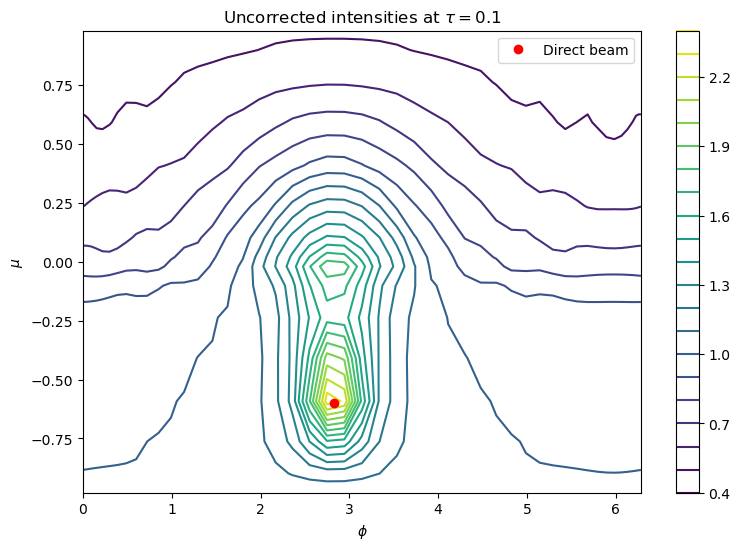

In [62]:
plot = u(tau_pt, phi_arr)[reorder_mu]

fig = plt.figure(figsize=(9, 6))
_contour = plt.contour(MU_ARR, PHI_ARR, plot, 20)
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contour)
plt.title(r"Uncorrected intensities at $\tau =$" + str(np.around(tau_pt, 3)))
plt.legend()

**Does the full solution satisfy the radiative transfer equation?**

Similar to the verification in section [3.6.3](#3.6.3-Verification-of-the-general-solution), this verification will not reflect quadrature and truncation errors.

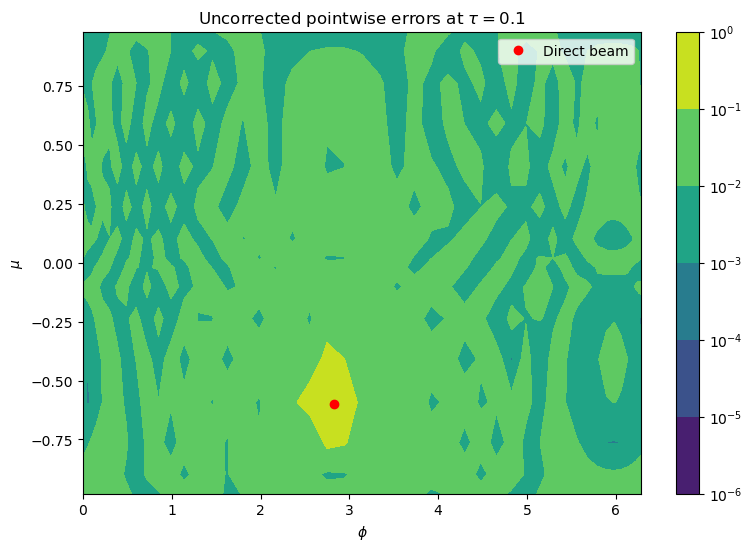

In [63]:
plot = error

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot, norm=mpl.colors.LogNorm())
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(r"Uncorrected pointwise errors at $\tau =$" + str(tau_pt))
plt.legend()

In [64]:
print("At tau = " + str(tau_pt))
print("Max pointwise error = ", np.max(error))

At tau = 0.1
Max pointwise error =  0.3073160672284381


### 3.7.2 NT corrections

This subsection summarizes the main points from [[11]](#cite-NT1988) and from *Appendix A* of [[5]](#cite-STWLE2000) but omits most of the mathematical explanation. Recall that $\tau^*, \omega^*, p^*$ denote $\delta-M$ scaled parameters and $f$ is the scattering fraction into peak. Nakajima-Tanaka (NT) corrections are disabled by default, enable them with the flag `NT_cor = True`. Note that if $I_0 = 0$, $f = 0$ or only $\text{NLeg}$ coefficients are supplied in `Leg_coeffs_all`, then NT corrections will remain disabled.

The $\delta-M$ method allows for accurate flux computation, but intensity values remain inaccurate particularly at backscattering angles and around the direct beam. These inaccuracies are largely caused by truncation of the Legendre series of the phase function. Nakajima and Tanaka proposed intensity corrections to reduce these accuracies. This correction is applied to the intensity but not to the flux as the latter is already accurate. This unfortunately means that flux values calculated by integrating the corrected intensity will differ slightly from values given by the flux functions. Note that NT corrections ignore, or rather have not been derived for, the isotrophic internal sources $s$, see [[4, section 3.6.3]](#cite-STWLE2000), and they ignore the BDRF, see section [Verification and visualization: NT corrected](#3.7.3-Verification-and-visualization:-NT-corrected).

**TMS correction**

For the first of two NT corrections, named *TMS*, we approximate $u_\text{true} \approx u_\text{TMS} = u^* + \left(\tilde{u}_1^* - u_1^*\right)$. We have that $u_1^*$ and $\tilde{u}_1^*$ are true solutions to the single-scattering equations for

$$
\begin{aligned}
\mu \frac{\partial \tilde{u}_1^*(\tau^*, \mu, \phi)}{\partial \tau^*} &= \tilde{u}_1^*(\tau^*, \mu, \phi) -\frac{\omega^* I_0}{(1 - f) 4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right) \\
\mu \frac{\partial u_1^*(\tau^*, \mu, \phi)}{\partial \tau^*} &= u_1^*(\tau^*, \mu, \phi) -\frac{\omega^* I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)
\end{aligned}
$$

respectively. Note that by construction (section [1.3.1](#1.3.1-OPTIONAL:-Choose-delta-M-scaling)), $p^*$ has a finite number of (non-zero) Legendre coefficients. In contrast, $p$ is the original phase function and in general has infinite Legendre coefficients. Unlike the Henyey-Greenstein phase function, realistic phase functions derived from Mie equations generally only have series representations. This lack of a closed-form means that it is impossible to input the true $p$ into PythonicDISORT. Instead, we use a large (`NLeg_all`) number of Legendre coefficients to very accurately approximate $p$.

By superposition, every correction term, i.e. every term but $u^*$, must satisfy homogeneous BCs. This is not entirely true but we will discuss the complication later. We must also preserve the continuity of the full solution. We can solve for $\left(\tilde{u}_1^* - u_1^*\right)$ analytically. We will need to apply the TMS correction to the solution for each atmospheric layer. For $\tau \in [\tau_{l-1}, \tau_{l}]$, we have

$$
\begin{aligned}
\left(\tilde{u}_1^* - u_1^*\right)(\tau^*, \mu, \phi) &= \mathscr{B}_l(\mu, \phi)\left[\exp\left(-\frac{\tau^*}{\mu_0}\right) - \exp\left(\frac{\tau^* - \tau^*_{l}}{\mu} - \frac{\tau^*_{l}}{\mu_0}\right)\right] + \text{Contribution from layers below} \\
\left(\tilde{u}_1^* - u_1^*\right)(\tau^*, -\mu, \phi) &= \mathscr{B}_l(\mu, \phi)\left[\exp\left(-\frac{\tau^*}{\mu_0}\right) - \exp\left(\frac{\tau^*_{l-1} - \tau^*}{\mu} - \frac{\tau^*_{l-1}}{\mu_0}\right)\right] + \text{Contribution from layers above}
\end{aligned}
$$

The contributions of layer $j$ to the layers above and below it (assuming there are layers above and below) are

$$
\begin{aligned}
&\mathscr{B}_j(\mu, \phi)\left[\exp\left(\frac{\tau - \tau_{l-1}}{\mu} - \frac{\tau_{l-1}}{\mu_0}\right) - \exp\left(\frac{\tau - \tau_l}{\mu} - \frac{\tau_l}{\mu_0}\right) \right] \\
&\mathscr{B}_j(-\mu, \phi)\left[ \exp\left(\frac{\tau_l - \tau}{\mu} - \frac{\tau_l}{\mu_0}\right) - \exp\left(\frac{ \tau_{l-1} - \tau}{\mu} - \frac{\tau_{l-1}}{\mu_0}\right)\right]
\end{aligned}
$$

respectively. The correction source terms give

$$
\mathscr{B}_l(\mu, \phi) = \left(\frac{\mu_0}{\mu_0 + \mu}\right) \frac{\omega^*_l I_0}{4 \pi} \left(\frac{p_l}{1-f} - p^*_l\right)\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right)
$$

Note the possible singularities if $\mu = \mu_0$. This is a special case which we have not implemented.

**IMS correction**

The TMS correction substantially reduces the truncation error everywhere except around the direct beam. We introduce a second NT correction named *IMS* to address the errors of significant magnitude that remain. We incorporate the IMS with the approximation $u_\text{true} \approx u_\text{TMS} + u_\text{IMS}$. It is impractical to determine $u_\text{IMS}$ exactly and both [[5]](#cite-STWLE2000) and [[11]](#cite-NT1988) make many approximations, albeit different approximations, to determine $u_\text{IMS}$. We follow [[5]](#cite-STWLE2000) and approximate the IMS correction as

$$
\begin{aligned}
u_\text{IMS}(\tau, -\mu, \phi) \approx \frac{I_0}{4 \pi} \frac{\left(\bar{\omega} \bar{f}\right)^2}{1-\bar{\omega} \bar{f}}\left[2 p_r\left(-\mu, \phi ;-\mu_0, \phi_0\right)-p_r^2\left(-\mu, \phi ;-\mu_0, \phi_0\right)\right]\chi\left(\tau,-\mu,-\mu_0',-\mu_0'\right)
\end{aligned}
$$

for $\mu > 0$, and $u_\text{IMS}(\tau, -\mu, \phi) \approx 0$ for $\mu \leq 0$, i.e. the correction only applies to the downward intensities. We have that $p_r = p - p^*$ is the residual phase function from the $\delta-M$ approximation which we previously approximated as a delta function (section [1.3.1](#1.3.1-OPTIONAL:-Choose-delta-M-scaling)) and

$$
p_r^2\left(-\mu, \phi ;-\mu_0, \phi_0\right) = \frac{1}{4 \pi} \int_0^{2 \pi} \int_{-1}^1 p_r\left(-\mu, \phi ; \mu', \phi'\right) p_r\left(\mu', \phi' ;-\mu_0, \phi_0\right) \mathrm{d} \phi' \mathrm{d} \mu'
$$

Using the series expansion for the residual phase function and optical properties that are averaged over all atmospheric layers (explicit formulas given below), we get

$$
\begin{aligned}
u_\text{IMS}\approx \frac{I_0}{4 \pi} \frac{\left(\bar{\omega} \bar{f}\right)^2}{1-\bar{\omega} \bar{f}}\left[\sum_{\ell=0}^\infty (2\ell + 1) \left(2\bar{g}_\ell - \bar{g}_\ell^2\right)P_\ell(\nu)\right]\chi\left(\tau, -\mu, -\mu_0', -\mu_0'\right)
\end{aligned}
$$

As with $p$, we truncate the series at `NLeg_all` and assume the remaining terms are negligible.


Next, we have the function

$$
\begin{aligned}
&\chi\left(\tau, -\mu, -\mu', -\mu^{\prime \prime}\right) = \frac{\exp\left({-\tau \big/ \mu}\right)}{\mu \mu'} \int_0^\tau \exp\left(\frac{t}{\mu} - \frac{t}{\mu'}\right) \left(\int_0^t \exp\left(\frac{t'}{\mu'} - \frac{t'}{\mu^{\prime \prime}}\right) \mathrm{d} t' \right)\mathrm{d} t \\
&\implies \chi\left(\tau, -\mu, -\mu_0', -\mu_0'\right) = \frac{1}{x\mu\mu'_0}\left[\left(\tau-\frac{1}{x}\right) \exp\left(-\frac{\tau}{\mu_0'}\right)+\frac{\exp\left(-\tau\big/\mu\right)}{x}\right], \quad x = \frac{1}{\mu}-\frac{1}{\mu_0'}
\end{aligned}
$$

which is further detailed in [[5]](#cite-STWLE2000). Since there are cases in which $\mu_0 = \mu_0'$, we do not allow $\mu_0$ to coincide with a quadrature angle (see section [1.4](#1.4-Choose-direct-beam-source)) to prevent singularities in the $x$ term. Singularities may still arise but are very unlikely given this precaution. Dithering can prevent singularities altogether but we have not implemented it. 

Finally, we have from [[5]](#cite-STWLE2000) the optical values that are averaged over all atmospheric layers, as well as a scaled $\mu_0$:

$$
\begin{aligned}
\bar{\omega}&=\sum_{l=1}^L \omega_l \tau_l \bigg/ \sum_{l=1}^L \tau_l \\
\bar{f}&=\sum_{l=1}^L f_l \omega_l \tau_l \bigg/ \sum_{l=1}^L \omega_l \tau_l \\
\bar{g}_{\ell}&=\sum_{l=1}^L g_{l, \ell}^r \omega_l \tau_l \bigg/ \sum_{l=1}^L f_l \omega_l \tau_l \\
g_{l, \ell}^r &= 
\begin{cases} f_l, &\ell \leq \text{NLeg} \\
g_{l, \ell}, &\ell > \text{NLeg} \end{cases} \\
\mu_0' &= \frac{\mu_0} {1-\bar{\omega} \bar{f}}
\end{aligned}
$$

**Further NT corrections**

If the BDRF is strongly peaked then we would face the same problems as described in section [1.3.1](#1.3.1-OPTIONAL:-Choose-delta-M-scaling). It is possible to adapt $\delta-M$ scaling and NT corrections to the BDRF and these are implemented in version 3 and newer of Stamnes' DISORT, see [[9]](#cite-LSJLTWS2015). These have not been implemented in PythonicDISORT though.

### 3.7.3 Verification and visualization: NT corrected

We include the (Lambertian) BDRF and (isotropic) BCs.

In [65]:
# Include the (Lambertian) BDRF and (isotropic) BCs

# With delta-M scaling but without NT corrections
u_dM = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    Leg_coeffs_BDRF=Leg_coeffs_BDRF,
    b_pos=b_pos,
    b_neg=b_neg,
    f_arr=f_arr[0],
)[-1]

# With both delta-M scaling and NT corrections
u_NT = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    Leg_coeffs_BDRF=Leg_coeffs_BDRF,
    b_pos=b_pos,
    b_neg=b_neg,
    f_arr=f_arr[0],
    NT_cor=True
)[-1]

**Does the full solution satisfy the BCs?**

If there is no surface reflection the NT corrected full solution would satisfy the BCs. If there is surface reflection, however, we would have had corrected the intensity without correcting the reflected intensity. Consequently, the BoA BC would no longer be satisfied. We could attempt to use the BDRF instead of homogeneous BCs in the initial value problems (IVPs) for the NT corrections but then the IVPs would likely be intractable. We observe that the error in the BCs is small, at least for current parameters, and so we will simply ignore it. This is also the choice Stamnes et. al. make in their DISORT, see [[5, section 3.6.3]](#cite-STWLE2000).

The BC at ToA remains satisfied:

In [66]:
# Setup for tests

# Ensure the BCs are of the correct shape for the test
if scalar_b_pos:
    b_pos_m = np.zeros((N, NLoops))
    b_pos_m[:, 0] = b_pos
else:
    b_pos_m = b_pos[:, m]
if scalar_b_neg:
    b_neg_m = np.zeros((N, NLoops))
    b_neg_m[:, 0] = b_pos
else:
    b_neg_m = b_neg[:, m]

# At top of atmosphere
assert np.allclose(
    u_NT(0, phi_arr)[N:, :],
    b_neg_m @ np.cos(np.arange(NLoops)[:, None] * (phi0 - phi_arr)),
)

print("Passed all tests")

Passed all tests


Using the true, NT corrected, surface reflection we see that the BC at BoA is no longer satisfied, though the error is small:

In [67]:
BDRF_contribution_NT = np.einsum(
    "ijkl, kl, k, l -> ij",
    BDRF(mu_arr_pos, phi_arr, -mu_arr_pos, phi_arr),
    mu_arr_pos[:, None] * u_NT(tau_arr[-1], phi_arr)[N:, :],
    W,
    full_weights_phi,
    optimize=True,
) / pi + (I0 * mu0) / pi * np.exp(-scaled_tau_arr_with_0[-1] / mu0) * BDRF(
    mu_arr_pos, phi_arr, -mu0, phi0
)
BC_Error = np.abs(
    u_NT(tau_arr[-1], phi_arr)[:N, :]
    - (
        b_pos_m @ np.cos(np.arange(NLoops)[:, None] * (phi0 - phi_arr))
        + BDRF_contribution_NT
    )
)

print("The BC at BoA is satisfied:", np.allclose(BC_Error, 0))
print(
    "Max pointwise error = ",
    np.max(BC_Error),
)

The BC at BoA is satisfied: False
Max pointwise error =  1.9987913324470696e-08


If we instead use the $\delta-M$ scaled but not NT corrected surface reflection we see that the BC at BoA is satisfied:

In [68]:
BDRF_contribution_dM = np.einsum(
    "ijkl, kl, k, l -> ij",
    BDRF(mu_arr_pos, phi_arr, -mu_arr_pos, phi_arr),
    mu_arr_pos[:, None] * u_dM(tau_arr[-1], phi_arr)[N:, :],
    W,
    full_weights_phi,
    optimize=True,
) / pi + (I0 * mu0) / pi * np.exp(-scaled_tau_arr_with_0[-1] / mu0) * BDRF(
    mu_arr_pos, phi_arr, -mu0, phi0
)


# At bottom of atmosphere
assert np.allclose(
    u_NT(tau_arr[-1], phi_arr)[:N, :],
    b_pos_m @ np.cos(np.arange(NLoops)[:, None] * (phi0 - phi_arr))
    + BDRF_contribution_dM,
)
print("Passed all tests")

Passed all tests


**Intensity plot at chosen** $\tau$ **value**

In [69]:
# Plots will be created for only this value of tau
tau_pt = float(1e-1)  # Must be a float for auto-differentiation to work

In [70]:
LHS_NT = (
    mu_arr_RO[:, None]
    * ag.jacobian(lambda tau: u_NT(tau, phi_arr))(tau_pt)[reorder_mu, :]
)
RHS_NT = (
    u_NT(tau_pt, phi_arr)[reorder_mu]
    - (omega_l / (4 * pi))
    * np.einsum(
        "ijkl, kl, k, l -> ij",
        p_HG_muphi(mu_arr_RO, phi_arr, mu_arr_RO, phi_arr),
        u_NT(tau_pt, phi_arr)[reorder_mu],
        full_weights_mu_RO,
        full_weights_phi,
        optimize=True,
    )
    - (omega_l * I0 / (4 * pi))
    * p_HG_muphi(mu_arr_RO, phi_arr, -mu0, phi0)
    * np.exp(-tau_pt / mu0)
)
error_NT = np.abs(RHS_NT - LHS_NT)

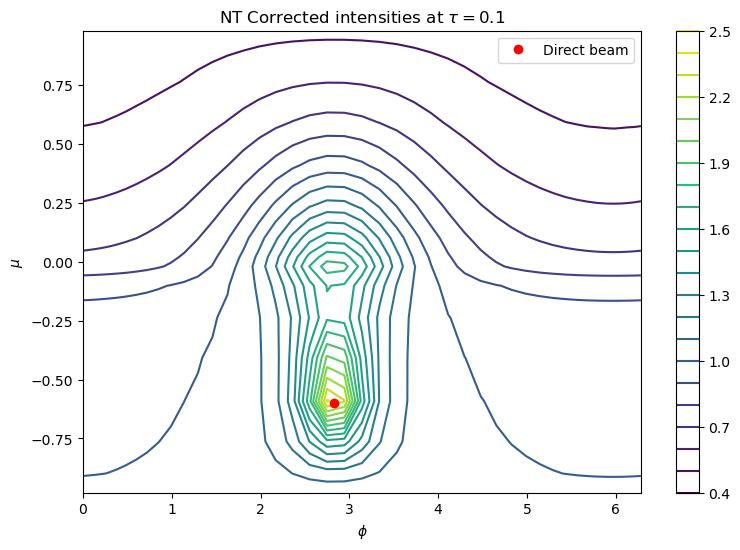

In [71]:
plot = u_NT(tau_pt, phi_arr)[reorder_mu]

fig = plt.figure(figsize=(9, 6))
_contour = plt.contour(MU_ARR, PHI_ARR, plot, 20)
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contour)
plt.title(r"NT Corrected intensities at $\tau =$" + str(np.around(tau_pt, 3)))
plt.legend()

**Does the full solution satisfy the radiative transfer equation?**

Similar to the verification in section [3.6.3](#3.6.3-Verification-of-the-general-solution), this verification will not reflect quadrature and truncation errors.

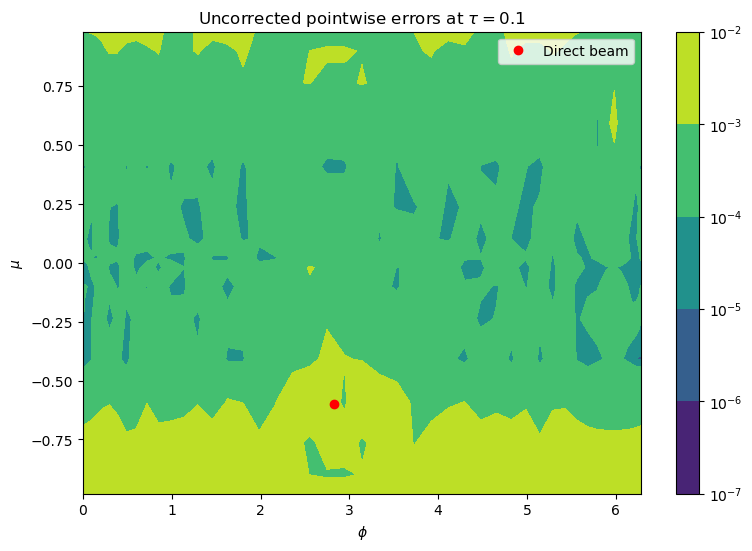

In [72]:
plot = error_NT

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot, norm=mpl.colors.LogNorm())
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(r"Uncorrected pointwise errors at $\tau =$" + str(tau_pt))
plt.legend()

In [73]:
print("At tau = " + str(tau_pt))
print("Max pointwise error = ", np.max(error_NT))

At tau = 0.1
Max pointwise error =  0.005251539451188947


## 3.8 Computation of flux

PythonicDISORT also returns the positive (upward) and negative (downward) flux functions. We have that

$$
F_\text{total}^\pm(\tau) = F_\text{diffuse}^\pm(\tau) + F_\text{direct}^\pm(\tau)
$$


**Direct (beam) flux**

Since the direct beam is

$$u_\text{direct}(\tau, \mu, \phi) = I_0 \delta(\mu + \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)$$

and $\mu_0 > 0$, we have 

$$F_\text{direct}^+(\tau) \equiv 0, \quad F_\text{direct}^-(\tau) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$$

**Diffuse flux**

The diffuse flux equals

$$
\begin{aligned}
F_\text{diffuse}^\pm(\tau) &= \int_{0}^{1} \int_{0}^{2 \pi} \mu u\left(\tau, \pm\mu, \phi\right) \mathrm{d} \phi \mathrm{d} \mu \\
&= \sum_{m=0}^\infty \left(\int_{0}^{1} \mu u^m(\tau, \pm\mu) \mathrm{d} \mu \int_{0}^{2 \pi} \cos\left(m\left(\phi_0 - \phi\right)\right) \mathrm{d} \phi \right) \\
&= 2\pi \int_{0}^{1} \mu u^0\left(\tau, \pm\mu\right) \mathrm{d} \mu \\
&\approx 2\pi \sum_{i = 1}^N w_i\mu_i u^0\left(\tau, \pm\mu_i\right)
\end{aligned}
$$

where we used the cosine expansion of $u$ from section [3.2](#3.2-Fourier-expansion-of-solution). In the last line we approximated the $\mu$ integral by the Gauss-Legendre quadrature rule that we used previously. Only the $0$th moment matters for the flux. The upwelling and downwelling are respectively 

$$F_\text{total}^+(0), \quad F_\text{total}^-(\tau_\text{BoA})$$ 

### 3.8.1 Impact of delta-M scaling on flux calculations

When we perform $\delta-M$ scaling we artificially augment the direct beam at the expense of the diffuse radiation. If we only cared about the total upward and downward flux, then our calculations will be identical to above. If we wish to distinguish between direct and diffuse fluxes like in Stamnes' DISORT [[3]](#cite-LSJLTWS2015), then we need to exercise more caution. The direct fluxes must be

$$F_\text{direct}^+(\tau) \equiv 0, \quad F_\text{direct}^-(\tau) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$$

With $\delta-M$ scaling, however, we get a larger value for the downward direct flux since the direct beam was augmented, i.e.

$$F_\text{direct}^-(\tau^*) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau^*\right) > I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right) = F_\text{direct}^-(\tau)$$

Therefore, we need to re-classify the additional downward flux from direct to diffuse, as is done in Stamnes' DISORT.

### 3.8.2 Verification of flux

**Does integrating the intensity functions produce the flux functions?**

This test will fail if NT corrections are enabled, i.e. `NT_cor = True`, because the corrections are applied only to the intensity and not the fluxes. This test can be tweaked to pass if $\delta-M$ scaling is activated, i.e. `f > 0`, but as it is implemented now it will fail.

In [74]:
Ntau = 1000 # Number of tau test points
tau_test_arr = np.random.random(Ntau) * tau_arr[-1]

# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1  
phi_arr, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi)

In [75]:
# No NT corrections or delta scaling but includes (isotropic) BCs
flux_up, flux_down, u = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    b_pos=b_pos,
    b_neg=b_neg,
)[1:]
u_cache = u(tau_test_arr, phi_arr)

In [76]:
flux_up_test = np.einsum(
    "itp, i, p -> t",
    mu_arr_pos[:, None, None] * u_cache[:N, :],
    W,
    full_weights_phi,
    optimize=True,
)
flux_down_test = np.einsum(
    "itp, i, p -> t",
    mu_arr_pos[:, None, None] * u_cache[N:, :],
    W,
    full_weights_phi,
    optimize=True,
)

The errors come from the quadrature.

In [77]:
print("Flux up")
print(
    "Max pointwise error = ",
     np.linalg.norm(flux_up(tau_test_arr) - flux_up_test, ord=np.infty),
)
print()
print("Flux down (diffuse only)")
print(
    "Max pointwise error = ",
    np.linalg.norm(flux_down(tau_test_arr)[0] - flux_down_test, ord=np.infty),
)

Flux up
Max pointwise error =  9.394440780852165e-11

Flux down (diffuse only)
Max pointwise error =  3.5133851383761794e-10


**Does** $\delta-M$ **scaling result in more accurate fluxes?**

We increase $g$ to $0.9$ to make the phase function more anisotropic to better demonstrate the effect of $\delta-M$ scaling.

In [78]:
g_dm = 0.9
Leg_coeffs_all_dm = g_dm ** np.arange(128)
f = Leg_coeffs_all_dm[NLeg]

In [79]:
# Fluxes without delta-scaling
flux_up, flux_down = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0], 
    NQuad, 
    Leg_coeffs_all_dm,
    mu0, I0, phi0, 
    only_flux=True
)[1:]

# Fluxes with delta-scaling
flux_up_dS, flux_down_dS = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all_dm,
    mu0, I0, phi0,
    only_flux=True,
    f_arr=f,
)[1:]

# Fluxes calculated using large NQuad and NLeg
# (we take this as the "true" solution against which to measure error)
flux_up_true, flux_down_true = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0], 
    128, 
    Leg_coeffs_all_dm, 
    mu0, I0, phi0, 
    only_flux=True,
    f_arr=f,
)[1:]

In [80]:
print("Without delta-scaling, i.e. f =", 0)
print(
    "Flux up: Max pointwise error =",
    np.max(np.abs(flux_up(tau_test_arr) - flux_up_true(tau_test_arr))),
)
print(
    "Flux down: Max pointwise error =",
    np.max(
        np.abs(
            np.sum(flux_down(tau_test_arr), axis=0)
            - np.sum(flux_down_true(tau_test_arr), axis=0)
        ),
    ),
)
print()

print("With delta-scaling, f =", f)
print(
    "Flux up: Max pointwise error =",
    np.max(np.abs(flux_up_dS(tau_test_arr) - flux_up_true(tau_test_arr))),
)
print(
    "Flux down: Max pointwise error =",
    np.max(
        np.abs(
            np.sum(flux_down_dS(tau_test_arr), axis=0)
            - np.sum(flux_down_true(tau_test_arr), axis=0)
        ),
    ),
)

Without delta-scaling, i.e. f = 0
Flux up: Max pointwise error = 0.0005494664924750592
Flux down: Max pointwise error = 0.0009236746293335152

With delta-scaling, f = 0.18530201888518416
Flux up: Max pointwise error = 0.00016073350460377167
Flux down: Max pointwise error = 9.582614193792693e-05


### 3.8.3 Reflectance and transmittance

**Incident flux**

In order to compute the reflectance and transmittance, we first need to determine the incident flux at each boundary. This includes both the direct flux from the direct beam at $\tau = 0$, which equals $I_0 \mu_0$ (see section [3.8](#3.8-Computation-of-flux)), and flux from the boundary conditions.

Focusing on the BCs, recall that they are

$$
u\left(\tau_\text{BoA}, \mu_i, \phi \right) = \sum_{m = 0}^{\text{NLoops}}b^+_{im}\cos(m(\phi_0 - \phi)), \quad u(0, -\mu_i, \phi) = \sum_{m = 0}^{\text{NLoops}}b^-_{im}\cos(m(\phi_0 - \phi)) \quad i = 1, \dots, N
$$

The incident flux from the BCs, which we denote $F_{b^\pm}$, are

$$F_{b^\pm} = 2 \pi \sum_{i = 0}^N w_i \mu_i b^\pm_{i0}$$

respectively, where $w_i$ are quadrature weights.  Once again, only the $0$th moment matters for the flux. If the BCs are constant over $\mu$, we will instead have 

$$F_{b^\pm} = \pi b^\pm$$

**Computation and interpretation of reflectance and transmittance values**

Reflectance, $\mathscr{R}$, and transmittance, $\mathscr{T}$, can only be computed if the incident radiation comes entirely from one side of the atmosphere, usually downward onto the top layer. Moreover, we generally want to calculate reflectance and transmittance with respect to a specific source. As an example, we calculate the reflectance and transmittance with respect to the direct beam:

$$\mathscr{R} = \frac{F_\text{Total}^+(0)}{I_0 \mu_0}, \quad \mathscr{T} = \frac{F_\text{Total}^-(\tau_0)}{I_0 \mu_0}$$

which requires us to set the BCs $b^\pm = 0$.

In [81]:
# Example calculation
flux_up, flux_down = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0], 
    NQuad, 
    Leg_coeffs_all[-1, :],
    mu0, I0, phi0, 
    only_flux=True
)[1:]


print("Reflectance =", flux_up(0) / (I0 * mu0))
print("Transmittance =", np.sum(flux_down(tau_arr[-1]), axis=0) / (I0 * mu0))

Reflectance = 0.25208852579281227
Transmittance = 0.07552126568690122


# 4. Solve for multiple layers

If we have multiple atmospheric layers, they will be coupled through their BCs as we require the solution to be continuous in $\tau$. Notice that the BCs are only used to solve for the coefficients of the homogeneous solution. Hence, we first solve for the general solution of each layer up to unknown coefficients before solving for all the coefficients simultaneously through a generalization of section [3.6.2](#3.6.2-The-homogeneous-solution). We then construct the "full solution" for each layer as per section [3.7](#3.7-The-full-solution). The full solution for the entire multi-layer atmosphere branches to the "full solution" of individual layers depending on the $\tau$ input.

**Multi-layer generalization of section [3.6.2](#3.6.2-The-homogeneous-solution)**

Suppose we have $\text{NLayers} = L + 1$ layers demarcated by $[0, \tau_0], [\tau_0, \tau_1], [\tau_1, \tau_2], \dots, [\tau_{L-1}, \tau_L]$ with $\tau_L = \tau_\text{BoA}$. Denote $\mathscr{E}_i = \exp\left(-\mu_0^{-1} \tau_i\right)$. We have the BCs

$$
\begin{aligned}
&v^-(0) &&= b^-_m - B_0^- - \delta_{0m}\mathscr{v}^-_0(0) \\ 
v^+\left( \tau_{L} \right) - R&v^-\left(\tau_{L}\right) &&=  b^+_m + \left(\mathscr{X} + RB_L^- - B_L^+\right)\mathscr{E}_L + \delta_{0m}(R + I)\mathscr{v}^-_L(\tau_{L})
\end{aligned}
$$

Since the full solution is continuous in $\tau$ but neither particular solution is necessarily continuous in $\tau$, we have that

$$
\begin{aligned}
&v_0^-\left(\tau_0\right) + B_0^-\mathscr{E}_0 + \delta_{0m}\mathscr{v}^-_0(\tau_0) = v_1^-\left(\tau_0\right) + B_1^-\mathscr{E}_0 + \delta_{0m}\mathscr{v}^-_1(\tau_0) &&v_0^+\left(\tau_0\right) + B_0^+\mathscr{E}_0 + \delta_{0m}\mathscr{v}^+_0(\tau_0) = v_1^+\left(\tau_0\right) + B_1^+\mathscr{E}_0 + \delta_{0m}\mathscr{v}^+_1(\tau_0) \\
&v_1^-\left(\tau_1\right) + B_1^-\mathscr{E}_1 + \delta_{0m}\mathscr{v}^-_1(\tau_1) = v_2^-\left(\tau_1\right) + B_2^-\mathscr{E}_1 + \delta_{0m}\mathscr{v}^-_2(\tau_1) &&v_1^+\left(\tau_1\right) + B_1^+\mathscr{E}_1 + \delta_{0m}\mathscr{v}^+_1(\tau_1) = v_2^+\left(\tau_1\right) + B_2^+\mathscr{E}_1 + \delta_{0m}\mathscr{v}^+_2(\tau_1) \\
&\quad \vdots &&\quad \vdots\\
&v_{L-1}^-\left(\tau_{L-1}\right) + B_{L-1}^-\mathscr{E}_{L-1} + \delta_{0m}\mathscr{v}^-_{L-1}(\tau_{L-1}) &&v_{L-1}^+\left(\tau_{L-1}\right) + B_{L-1}^+\mathscr{E}_{L-1} + \delta_{0m}\mathscr{v}^+_{L-1}(\tau_{L-1}) \\
&= v_{L}^-\left(\tau_{L-1}\right) + B_{L}^-\mathscr{E}_{L-1} + \delta_{0m}\mathscr{v}^-_{L}(\tau_{L-1}) &&  = v_{L}^+\left(\tau_{L-1}\right) + B_{L}^+\mathscr{E}_{L-1} + \delta_{0m}\mathscr{v}^+_{L}(\tau_{L-1})
\end{aligned}
$$

Denote $E_{i} = E_l(\tau_i)$, where $E_l(\tau_i)$ is a diagonal matrix with $\exp(k_{lj}\tau_i)$ as diagonal entry $j$. We omit the index $l$ of $E_l(\tau_i)$ because it will always match the index of the accompanying eigenvector matrix $G_l$, which will in turn match the index of the coefficient vector $\xi_l$. The BCs produce a system with

$$
\begin{aligned}
\text{LHS} &= \begin{bmatrix} 
G^-_0 & 0 & 0 & & 0 & 0 \\ 
G^+_0 E_{0} & -G^+_1 E_{0} & 0 & & 0 & 0 \\ 
G^-_0 E_{0} & -G^-_1 E_{0} & 0 & & 0 & 0 \\ 
0 & G^+_1 E_{1} & -G^+_2 E_{1} & & 0 & 0 \\ 
0 & G^-_1 E_{1} & -G^-_2 E_{1} & & 0 & 0 \\
& & & \ddots & & \\
0 & 0 & 0 & & G^+_{L-1} E_{L-1} & -G^+_L E_{L-1} \\ 
0 & 0 & 0 & & G^-_{L-1} E_{L-1} & -G^-_L E_{L-1} \\
0 & 0 & 0 & & 0 & \left(G^+_L - RG^-_L\right) E_L
\end{bmatrix} 
\begin{bmatrix} 
\xi_0 \\ 
\xi_1 \\ 
\xi_2 \\ 
\vdots \\
\xi_{L-1} \\
\xi_L 
\end{bmatrix} \\
\text{RHS} &= \begin{bmatrix} b^-_m - B_0^- - \delta_{0m}\mathscr{v}^-_0(0) \\ 
\left(B^+_1 - B^+_0\right)\mathscr{E}_0 + \delta_{0m}\left(\mathscr{v}^+_1 - \mathscr{v}^+_0\right)(\tau_0)  \\
\left(B^-_1 - B^-_0\right)\mathscr{E}_0 + \delta_{0m}\left(\mathscr{v}^-_1 - \mathscr{v}^-_0\right)(\tau_0) \\ 
\left(B^+_2 - B^+_1\right)\mathscr{E}_1 + \delta_{0m}\left(\mathscr{v}^+_2 - \mathscr{v}^+_1\right)(\tau_1) \\
\left(B^-_2 - B^-_1\right)\mathscr{E}_1 + \delta_{0m}\left(\mathscr{v}^-_2 - \mathscr{v}^-_1\right)(\tau_1)\\ 
\vdots \\
\left(B^+_{L} - B^+_{L-1}\right)\mathscr{E}_{L-1} + \delta_{0m}\left(\mathscr{v}^+_{L} - \mathscr{v}^+_{L-1}\right)(\tau_{L-1}) \\ 
\left(B^-_{L} - B^-_{L-1}\right)\mathscr{E}_{L-1} + \delta_{0m}\left(\mathscr{v}^-_{L} - \mathscr{v}^-_{L-1}\right)(\tau_{L-1}) \\ 
b^+_m + \left(\mathscr{X} + RB_L^- - B_L^+\right)\mathscr{E}_L + \delta_{0m}(R + I)\mathscr{v}^-_L(\tau_{L})
\end{bmatrix}
\end{aligned}
$$

As in section [3.6.2](#3.6.2-The-homogeneous-solution), we have additional superscripts $+$ and $-$ to denote only positive or only negative eigenvalues respectively. The multi-layer Stamnes-Conklin's substitutions [[4]](#cite-SC1984) are 

$$
\begin{aligned}
&\xi_0^- = C_0^- &&\xi_0^+ = E^-_0 C_0^+ \\
&\xi_1^- = E^+_0 C_1^- &&\xi_1^+ = E^-_1 C_1^+ \\
&\quad \vdots &&\quad \vdots \\
&\xi_L^- = E^+_{L-1} C_L^- && \xi_L^+ = E^-_L C_L^+
\end{aligned}
$$

Recall that the eigenvalues are arranged negative then positive, e.g. $G^+_1 E_1 = \begin{bmatrix} G^{+-}_1 E^-_1 & G^{++}_1 E^+_1 \end{bmatrix}$. Denote $E_{ij} = E^+_iE^-_j$. Every entry of $E_{ij}$ will have a negative exponent if $i < j$. After substitutions the LHS becomes

$$
\begin{bmatrix} 
G^{--}_0 & G^{-+}_0 E^-_0 & 0 & 0 & & 0 & 0 & 0 & 0 \\ 
G^{+-}_0 E^-_0 & G^{++}_0 & -G^{+-}_1 & -G^{++}_1 E_{01} & & 0 & 0 & 0 & 0 \\ 
G^{--}_0 E^-_0 & G^{-+}_0 & -G^{--}_1 & -G^{-+}_1 E_{01} & & 0 & 0 & 0 & 0 \\ 
& & & & \ddots & & & & \\
0 & 0 & 0 & 0 & & G^{+-}_{L-1} E_{L-2,\,L-1} & G^{++}_{L-1} & -G^{+-}_{L} & -G^{++}_{L}E_{L-1,\,L} \\ 
0 & 0 & 0 & 0 & & G^{--}_{L-1} E_{L-2,\,L-1} & G^{-+}_{L-1} & -G^{--}_{L} & -G^{-+}_{L}E_{L-1,\,L} \\
0 & 0 & 0 & 0 & & 0 & 0 & \left(G^+_L - RG^-_L\right)^-E_{L-1,\,L} & \left(G^+_L - RG^-_L\right)^+
\end{bmatrix} 
\begin{bmatrix} 
C^-_0 \\ 
C^+_0 \\ 
C^-_1 \\ 
C^+_1 \\ 
\vdots \\
C^-_{L-1} \\
C^+_{L-1} \\
C^-_L \\
C^+_L \\
\end{bmatrix} 
$$

while the RHS remains the same, and this system will always be well-conditioned.

**Sparsity of the LHS matrix**

The LHS matrix has a density of

$$\frac{4N^2(2L + 1)}{(2N(L + 1))^2} = \frac{2L + 1}{(L + 1)^2}$$

and so it gets sparser the more layers there are in the atmosphere. We recommend using `scipy.sparse` for the LHS matrix if the density of the matrix is less than $1 / 3$ or equivalently when $L \geq 5 \iff \text{NLayers} \geq 6$ but users may choose their own threshold using the `use_sparse_NLayers` argument in `pydisort`, see section [1.2](#1.2-Choose-computational-parameters).

**Example assembly of LHS matrix**

In [82]:
G_collect_m = np.random.random((NLayers, NQuad, NQuad))
K_collect_m = np.random.random((NLayers, NQuad))

In [83]:
# Assemble LHS
dim = NLayers * NQuad
if NLayers >= use_sparse_NLayers:
    LHS = sc.sparse.lil_matrix((dim, dim))
else:
    LHS = np.zeros((dim, dim))

G_0_nn = G_collect_m[0, N:, :N]
G_0_np = G_collect_m[0, N:, N:]
G_L_pn = G_collect_m[-1, :N, :N]
G_L_nn = G_collect_m[-1, N:, :N]
G_L_pp = G_collect_m[-1, :N, N:]
G_L_np = G_collect_m[-1, N:, N:]
E_Lm1L = np.exp(
    K_collect_m[-1, :N] * (scaled_tau_arr_with_0[-1] - scaled_tau_arr_with_0[-2])
)
if m < NBDRF:
    BDRF_LHS_contribution_neg = R @ G_L_nn
    BDRF_LHS_contribution_pos = R @ G_L_np
else:
    BDRF_LHS_contribution_neg = 0
    BDRF_LHS_contribution_pos = 0

# BCs for the entire atmosphere
LHS[:N, :N] = G_0_nn
LHS[:N, N : 2 * N] = (
    G_0_np
    * np.exp(K_collect_m[0, :N] * scaled_tau_arr_with_0[1])[None, :]
)
LHS[-N:, -2 * N : -N] = (G_L_pn - BDRF_LHS_contribution_neg) * E_Lm1L[None, :]
LHS[-N:, -N:] = G_L_pp - BDRF_LHS_contribution_pos

# Interlayer BCs / continuity BCs
for l in range(NLayers - 1):
    G_l_pn = G_collect_m[l, :N, :N]
    G_l_nn = G_collect_m[l, N:, :N]
    G_l_ap = G_collect_m[l, :, N:]
    G_lp1_an = G_collect_m[l + 1, :, :N]
    G_lp1_pp = G_collect_m[l + 1, :N, N:]
    G_lp1_np = G_collect_m[l + 1, N:, N:]
    scaled_tau_arr_lm1 = scaled_tau_arr_with_0[l]
    scaled_tau_arr_l = scaled_tau_arr_with_0[l + 1]
    scaled_tau_arr_lp1 = scaled_tau_arr_with_0[l + 2]
    # Postive eigenvalues
    K_l_pos = K_collect_m[l, N:]
    K_lp1_pos = K_collect_m[l + 1, N:]

    E_lm1l = np.exp(K_l_pos * (scaled_tau_arr_lm1 - scaled_tau_arr_l))
    E_llp1 = np.exp(K_lp1_pos * (scaled_tau_arr_l - scaled_tau_arr_lp1))
    block_row = np.hstack(
        [
            np.vstack([G_l_pn * E_lm1l[None, :], G_l_nn * E_lm1l[None, :]]),
            G_l_ap,
            -G_lp1_an,
            -np.vstack([G_lp1_pp * E_llp1[None, :], G_lp1_np * E_llp1[None, :]]),
        ]
    )
    LHS[
        N + l * NQuad : N + (l + 1) * NQuad, l * NQuad : l * NQuad + 2 * NQuad
    ] = block_row

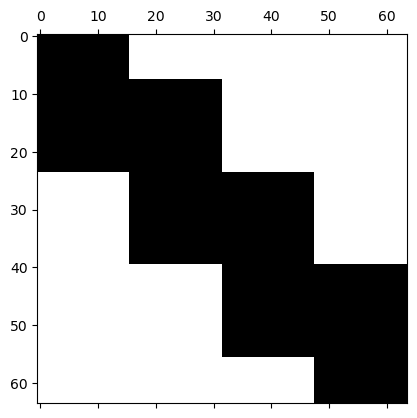

In [84]:
#%matplotlib ipympl

plt.spy(LHS)

## 4.1 Memory inefficiencies

PythonicDISORT has been optimized for speed over memory usage. The output functions store multiple tensors, the largest of which has dimensions $\text{NLoops} \times \text{NLayers} \times \text{NQuad} \times \text{NQuad}$. When $u$ is called, a tensor of dimensions $\text{NLoops} \times \text{Ntau} \times \text{NQuad} \times \text{NQuad}$ is constructed, where $\text{Ntau}$ is the length of the $\tau$ input and is in general large. A more memory efficient method would be to input the $\tau$ and $\phi$ values into `pydisort` and have the output be the solution evaluated at those values rather than a function. This is how Stamnes' DISORT works [[2]](#cite-STWJ1988). This way, the largest tensor that PythonicDISORT needs to construct will have dimensions $\text{Ntau} \times \text{NQuad} \times \text{NQuad}$, but the tradeoff will be less speed and flexibility. Even within our current design paradigm there are avenues for memory optimization. Depending on the phase function of each atmospheric layer, the $\text{NLoops} \times \text{NLayers} \times \text{NQuad} \times \text{NQuad}$ tensor may be sparse. Therefore, it may be beneficial to implement a sparse tensor framework and memory efficient variants of PythonicDISORT.

## 4.2 Verification of multi-layer solver

**When a single-layer atmosphere is broken into multiple homogeneous layers do we get the same results?**

In [85]:
Ntau = 1000

tau_test_arr = np.sort(np.random.random(Ntau) * tau_arr[-1])

In [86]:
# We turn everything on
flux_up_1layer, flux_down_1layer, u_1layer = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    b_pos=b_pos,
    b_neg=b_neg,
    f_arr=f_arr[0],
    s_poly_coeffs=s_poly_coeffs[0, :],
    NT_cor=True,
)[1:4]

flux_up_4layers, flux_down_4layers, u_4layers = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_pos=b_pos,
    b_neg=b_neg,
    f_arr=f_arr,
    s_poly_coeffs=s_poly_coeffs,
    NT_cor=True,
)[1:4]

In [87]:
assert np.allclose(flux_up_1layer(tau_test_arr), flux_up_4layers(tau_test_arr))
assert np.allclose(flux_down_1layer(tau_test_arr), flux_down_4layers(tau_test_arr))
assert np.allclose(u_1layer(tau_test_arr, phi_arr), u_4layers(tau_test_arr, phi_arr))

print("Passed all tests")

Passed all tests


# 5. Timing PythonicDISORT

The time taken is dependent on hardware and on input parameters, but this section should give a sense of the speed of PythonicDISORT. PythonicDISORT was timed on a personal laptop and the parameters that affect its speed the most are

In [88]:
print("NQuad, NLeg, NLoops, NLayers =", NQuad, NLeg, NLoops, NLayers)

NQuad, NLeg, NLoops, NLayers = 16 16 16 4


**Time taken to solve the radiative transfer equation (for a multi-layer atmosphere)**

In [89]:
print("Intensity")
%timeit PythonicDISORT.pydisort(tau_arr, omega_arr, NQuad, Leg_coeffs_all, mu0, I0, phi0)
print()

print("Intensity with blackbody emission")
%timeit PythonicDISORT.pydisort(tau_arr, omega_arr, NQuad, Leg_coeffs_all, mu0, I0, phi0, s_poly_coeffs=s_poly_coeffs)
print()

print("Intensity with blackbody emission and Lambertian BDRF")
%timeit PythonicDISORT.pydisort(tau_arr, omega_arr, NQuad, Leg_coeffs_all, mu0, I0, phi0, s_poly_coeffs=s_poly_coeffs, Leg_coeffs_BDRF=Leg_coeffs_BDRF)
print()

print("Only fluxes")
%timeit PythonicDISORT.pydisort(tau_arr, omega_arr, NQuad, Leg_coeffs_all, mu0, I0, phi0, only_flux=True)
print()

print("Only fluxes with delta-M scaling")
%timeit PythonicDISORT.pydisort(tau_arr, omega_arr, NQuad, Leg_coeffs_all, mu0, I0, phi0, only_flux=True, f_arr=f_arr)

Intensity
14.3 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Intensity with blackbody emission
15.5 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Intensity with blackbody emission and Lambertian BDRF
15.6 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Only fluxes
1.35 ms ± 6.63 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Only fluxes with delta-M scaling
1.39 ms ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**Time taken to evaluate the solution at a point**

In [90]:
# Setup
flux_up, flux_down, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
)[1:]

u_NT = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=True,
)[-1]

u_iso = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    s_poly_coeffs=s_poly_coeffs,
)[-1]

In [91]:
print("Intensity")
%timeit u(tau_test_arr[Ntau//2], phi_arr[Nphi//2])
print()

print("Intensity with NT corrections")
%timeit u_NT(tau_test_arr[Ntau//2], phi_arr[Nphi//2])
print()

print("Intensity with blackbody emission")
%timeit u_iso(tau_test_arr[Ntau//2], phi_arr[Nphi//2])
print()

print("Up and down fluxes respectively")
%timeit flux_up(0)
%timeit flux_down(tau_arr[-1])

Intensity
183 µs ± 2.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Intensity with NT corrections
2.37 ms ± 66.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Intensity with blackbody emission
460 µs ± 2.55 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Up and down fluxes respectively
57.2 µs ± 213 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
71.2 µs ± 770 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


See section [6.2](#6.2-Timing-Stamnes'-DISORT) for the runtimes of a Python-wrapped Stamnes' FORTRAN DISORT [[3]](#cite-Sta1999) for comparison. There are three factors which slow PythonicDISORT down significantly relative to Stamnes' DISORT. First, Python inherently has more overhead than FORTRAN code. This cannot be helped. Second, PythonicDISORT has two significant for-loops: one over the number of layers $l$ and another over the number of Fourier modes $m$. For-loops in Python are much slower than in FORTRAN. We hope to further optimize the Fourier mode for-loop going forward, possibly by parallelization. PythonicDISORT is otherwise almost entirely vectorized. Finally, our current implementation of the NT corrections seems slow and we hope to further optimize it.

# 6. Comparisons with Stamnes' DISORT

Inspired by [[12]](#cite-KS2022), we created a Python wrapper around version 4.0.99 of Stamnes' FORTRAN DISORT [[3]](#cite-Sta1999) using F2PY with `O3` optimizations. Note that Stamnes' DISORT has 32-bit precision whereas PythonicDISORT has 64-bit precision. We will compare pointwise the results from PythonicDISORT against those from Stamnes' DISORT. For the intensities, we expect difference ratios of less than $10^{-2}$ $(1\%)$ or absolute differences of less than $10^{-2}$. For the fluxes, we expect difference ratios of less than $10^{-3}$ $(0.1\%)$ or absolute differences of less than $10^{-2} \big/ \pi$.

**We do not compare intensities at polar angles that are within $10^\circ$ of the direct beam.** This is because there will be large inaccuracies at $\mu$ points that are extremely close to the direct beam even with NT corrections. This is reported by Stamnes et. al. [[2]](#cite-STWJ1988) and can be seen in section [Verification and visualization: NT corrected](#3.7.3-Verification-and-visualization:-NT-corrected). Stamnes et. al. do test their DISORT at exactly the direct beam, i.e. at $\mu = \mu_0$ and $\mu = -\mu_0$, but this is a special case which we have not implemented in PythonicDISORT.

**PythonicDISORT**

In [92]:
# PythonicDISORT
mu_arr, flux_up_NT, flux_down_NT, u_NT = PythonicDISORT.pydisort(
    tau_arr[-1], omega_arr[0],
    NQuad,
    Leg_coeffs_all[0, :],
    mu0, I0, phi0,
    f_arr=f_arr[0],
    NT_cor=True
)

**Setup for tests**

In [93]:
# mu_arr is arranged as it is for code efficiency and readability
# For presentation purposes we re-arrange mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# By default we do not compare intensities 1 degree around the direct beam
# The size of the region can be changed using the parameter below
deg_around_beam_no_compare = 1

theta_deg_pos = np.arccos(mu_arr_RO[NQuad // 2 :]) * 180 / pi
mu_to_compare_ind = np.where(
    np.tile(
        np.logical_or(
            theta_deg_pos > np.arccos(mu0) * 180 / pi + deg_around_beam_no_compare,
            theta_deg_pos < np.arccos(mu0) * 180 / pi - deg_around_beam_no_compare,
        ),
        2,
    )
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare_ind]

In [94]:
# Number of phi grid points
# This selection should ensure that the phi quadrature is at least as accurate as the mu quadrature
Nphi = int((NQuad * pi) // 2) * 2 + 1
phi_arr, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi)

Ntau = 1000 # Number of tau test points
tau_test_arr = np.random.random(Ntau) * tau_arr[-1]

MU_ARR, PHI_ARR = np.meshgrid(phi_arr, mu_arr_RO)

**Stamnes' DISORT**

Our F2PY-wrapped Stamnes DISORT (version 4.0.99) must be set up to run the following. We provide our `disort4.0.99_f2py` directory in our GitHub repository but it was designed for personal use (Windows + Conda) and we provide no guarantee that our setup will work for any other system.

In [95]:
import disort

In [96]:
# Test Problem 3a:  Henyey-Greenstein Scattering (Compare To Ref. VH2, Table 37)
nlyr = NLayers
nmom = NLeg
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([True, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.concatenate([[tau_arr[0]], np.diff(tau_arr)])
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = "Test Problem 3:  Henyey-Greenstein Scattering, g = 0.75 (Compare To Ref. VH2, Table 37)"
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [97]:
# Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                        pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                        temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                        rfldn, flup, dfdt, uavg, uu, albmed, trnmed)

**Flux comparisons**

In [98]:
print("Max pointwise differences")
print()
print("Upward (diffuse) fluxes")

diff_flux_up = np.abs(flup - flux_up_NT(tau_test_arr))
ratio_flux_up = diff_flux_up / np.clip(flup, a_min=1e-6, a_max=None)

print("Difference =", np.max(diff_flux_up))
print("Difference ratio =", np.max(ratio_flux_up))
print()
print("Downward (diffuse) fluxes")

diff_flux_down_diffuse = np.abs(rfldn - flux_down_NT(tau_test_arr)[0])
ratio_flux_down_diffuse = diff_flux_down_diffuse / np.clip(
    rfldn, a_min=1e-6, a_max=None
)
print("Difference =", np.max(diff_flux_down_diffuse))
print(
    "Difference ratio =",
    np.max(ratio_flux_down_diffuse),
)
print()
print("Direct (downward) fluxes")

diff_flux_down_direct = np.abs(rfldir - flux_down_NT(tau_test_arr)[1])
ratio_flux_down_direct = diff_flux_down_direct / np.clip(rfldir, a_min=1e-6, a_max=None)
print("Difference =", np.max(diff_flux_down_direct))
print(
    "Difference ratio =",
    np.max(ratio_flux_down_direct),
)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 5.039856175725888e-07
Difference ratio = 5.966449624341432e-05

Downward (diffuse) fluxes
Difference = 1.0112147554863782e-06
Difference ratio = 1.9213998296027157e-05

Direct (downward) fluxes
Difference = 3.8151735459734937e-07
Difference ratio = 1.126622703253104e-06


**Intensity comparisons**

In [99]:
diff = np.abs(uu - u_NT(tau_test_arr, phi_arr)[reorder_mu])[mu_to_compare_ind]
diff_ratio = diff / np.clip(uu[mu_to_compare_ind], a_min=1e-6, a_max=None)

In [100]:
max_diff_tau_index = np.argmax(np.max(np.max(diff, axis=0), axis=1))
max_ratio_tau_index = np.argmax(np.max(np.max(diff_ratio, axis=0), axis=1))

# Plots will be created for only these values of tau
diff_tau_pt = tau_test_arr[max_diff_tau_index]
ratio_tau_pt = tau_test_arr[max_ratio_tau_index]

In [101]:
print("At tau = " + str(diff_tau_pt))
print("Max pointwise difference =", np.max(diff[:, max_diff_tau_index, :]))

At tau = 1.1958311389326726
Max pointwise difference = 0.0066957571521344406


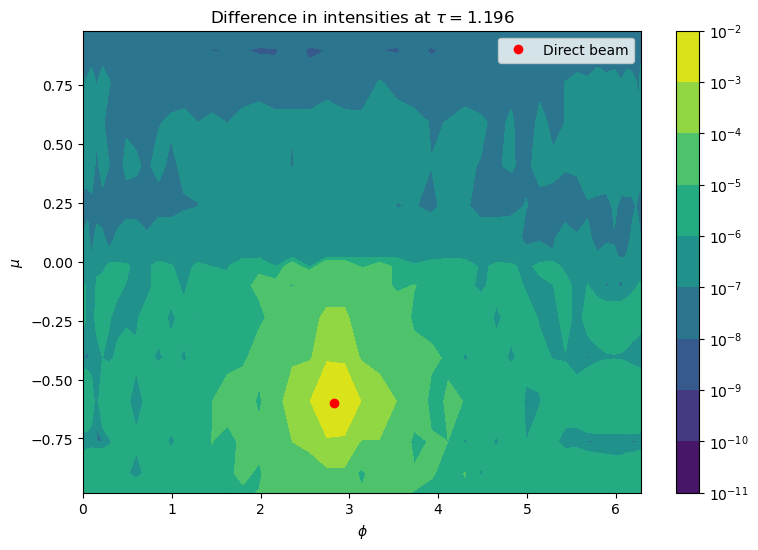

In [102]:
diff_plot = np.abs(uu - u_NT(tau_test_arr, phi_arr)[reorder_mu])
plot = diff_plot[:, max_diff_tau_index, :]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot, norm=mpl.colors.LogNorm())
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(r"Difference in intensities at $\tau =$" + str(np.around(diff_tau_pt, 3)))
plt.legend()

In [103]:
print("At tau = " + str(ratio_tau_pt))
print("Max pointwise difference ratio =", np.max(diff_ratio[:, max_ratio_tau_index, :]))

At tau = 0.007010144654437944
Max pointwise difference ratio = 0.0024957283902707263


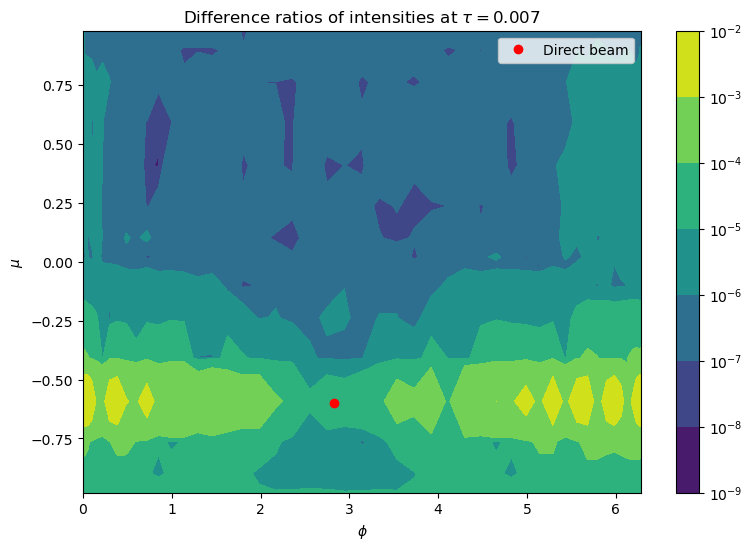

In [104]:
diff_ratio_plot = diff_plot / np.clip(uu, a_min=1e-6, a_max=None)
plot = diff_ratio_plot[:, max_ratio_tau_index, :]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot, norm=mpl.colors.LogNorm())
plt.plot(phi0, -mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(r"Difference ratios of intensities at $\tau =$" + str(np.around(ratio_tau_pt, 3)))
plt.legend()

## 6.1 PyTest

We use PyTest to implement test problems 1 to 9, 11, 14 and 15 of version 4.0.99 of Stamnes' FORTRAN DISORT [[3]](#cite-Sta1999). These test problems are coded, described and explained in `DISOTEST.txt` and `disotest.f90`. We omit problems and subproblems that test features or special cases like $\mu = \mu_0$ that we have not implemented, though we sometimes tweak `mu0 = 1` to `mu0 = 0.99` instead of omitting the subproblem. Test problem 10 is equivalent to our verification test in section [4.2](#4.2-Verification-of-multi-layer-solver) and we implemented the latter in PyTest. We also add a subproblem to test problem 5 to test our Lambertian BDRF. All test parameters are copied from `disotest.f90` and `DISOTESTAUX.f` unless stated otherwise. Except for test problem 10, we compare pointwise the results from PythonicDISORT against the corresponding results from Stamnes' DISORT which are saved in `.npz` files.

We compare flux and intensity values at random $\tau$ points and, for the intensity, at $\mu$ and $\phi$ quadrature points. We do not compare intensities at polar angles that are within $10^\circ$ of the direct beam. Our tolerance for the intensity and fluxes are respectively: a difference ratio of less than $10^{-2}$ $(1\%)$ or an absolute differences of less than $10^{-2}$; a difference ratio of less than $10^{-3}$ $(0.1\%)$ or a pointwise absolute differences of less than $10^{-2} \big/ \pi$. This is the exact same test method used above. **With PyTest installed, execute the console command** `pytest` **in the** `pydisotest` **directory to run these tests.** Add the flag `-s` to have the differences printed to console.

The Stamnes DISORT results which we test PythonicDISORT against can be re-generated using the Jupyter Notebooks in the `pydisotest` directory but this requires setting up the F2PY-wrapped Stamnes DISORT (version 4.0.99) which we used. We provide our `disort4.0.99_f2py` directory in our GitHub repository but it was designed for personal use (Windows + Conda) and we provide no guarantee that our setup will work for any other system.

## 6.2 Timing Stamnes' DISORT

We time our F2PY-wrapped Stamnes' DISORT rather than the original FORTRAN DISORT which is faster. Compare against PythonicDISORT's times in section [5](#5.-Timing-PythonicDISORT).

In [105]:
# We evaluate the solution at only one point
ntau = 1
utau = tau_test_arr[Ntau//2]
nphi = 1
phi = phi_arr[Nphi//2]


rho_accurate = np.zeros((numu, nphi))
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))

In [106]:
print("Intensity")
%timeit disort.disort(usrang, usrtau, ibcnd, False, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
print()

print("Only fluxes")
%timeit disort.disort(usrang, usrtau, ibcnd, True, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb, pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0, umu, phi, fbeam, fisot, albedo, btemp, ttemp, temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed)

Intensity
2.44 ms ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Only fluxes
1.14 ms ± 6.63 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<!--bibtex


@misc{KS2022, 
	title={pyRT_DISORT}, 
	url={https://github.com/kconnour/pyRT_DISORT}, 
	author={K. Connour and A. Stcherbinine}, 
	year={2022}
}

@inbook{Tre1996,
  author    = {Trefethen, L. N.},
  title     = {In Finite difference and spectral methods for ordinary and partial differential equations},
  chapter   = {Chapter 8. Chebyshev spectral methods},
  year      = {1996},
  pages     = {260–300}
}

@article{NT1988,
title = {Algorithms for radiative intensity calculations in moderately thick atmospheres using a truncation approximation},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {40},
number = {1},
pages = {51-69},
year = {1988},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(88)90031-3},
url = {https://www.sciencedirect.com/science/article/pii/0022407388900313},
author = {T. Nakajima and M. Tanaka},
abstract = {The efficiency of numerical calculations is discussed for selected algorithms employing the discrete ordinate method and the truncation approximation for the solar radiative intensity in moderately thick, plane-parallel scattering atmospheres. It is found that truncation of the phase function causes a significant error in the computed intensity and the magnitude of this error depends significantly on how the intensity is retrieved from the truncated radiative transfer equation. A newly developed retrieval algorithm, the IMS- method, yields the intensity field with an error ⪅1% when the number of discrete path is as small as 10 in the hemisphere for aerosol-laden atmospheres with optical thickness ⪅1.}
}

@article{YTA1971,
title = {Radiative heat transfer in water clouds by infrared radiation},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {11},
number = {6},
pages = {697-708},
year = {1971},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(71)90048-3},
url = {https://www.sciencedirect.com/science/article/pii/0022407371900483},
author = {Giichi Yamamoto and Masayuki Tanaka and Shoji Asano},
abstract = {Radiative heat transfer in water clouds is studied by the method of discrete ordinates, taking into account not only scattering, absorption and emission by cloud droplets but also absorption and emission by water vapor in the cloud. According to Semuelson the method of discrete ordinates is not very amenable to studies involving the intermediate optical thickness, because of instabilities that are inherent in the method for the intermediate optical thickness. A method of avoiding these instabilities is shown in this paper. Numerical calculation for the spectral region from 5 to 40 μ was carried out on the model altostratus clouds, and that only for the window region on the model stratocumulus and nimbostratus clouds. The radiative temperature change in a very thin cloud is everywhere cooling. With increasing cloud thickness, however, the upper parts of the cloud undergo cooling, while the lower parts undergo heating. The rate of both heating and cooling is largest near the surface. In a semi-infinitely thick cloud the cloud top undergoes cooling at a rate of about 30°C/hr and effective cooling extends to about 100 m interior from the cloud boundary.}
}

@book{Cha1960, 
      author = "S.  Chandrasekhar",
      title = "Radiative Transfer",
      year = "1960",
      publisher = "Dover",
}

@article{Wis1977,
      author = "W. J.  Wiscombe",
      title = "The Delta–M Method: Rapid Yet Accurate Radiative Flux Calculations for Strongly Asymmetric Phase Functions",
      journal = "Journal of Atmospheric Sciences",
      year = "1977",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "34",
      number = "9",
      doi = "10.1175/1520-0469(1977)034<1408:TDMRYA>2.0.CO;2",
      pages=      "1408 - 1422",
      url = "https://journals.ametsoc.org/view/journals/atsc/34/9/1520-0469_1977_034_1408_tdmrya_2_0_co_2.xml"
}

@article{Syk1951,
    author = {Sykes, J. B.},
    title = "{Approximate Integration of the Equation of Transfer}",
    journal = {Monthly Notices of the Royal Astronomical Society},
    volume = {111},
    number = {4},
    pages = {377-386},
    year = {1951},
    month = {08},
    abstract = "{The value of numerical integration in obtaining approximate solutions of an equation of transfer, and the different methods at our disposal, are discussed. It is shown that although the Newton-Cotes method, used by Kourganoff, is better than the Gauss method, used by Chandrasekhar, both are inferior to a new method, the double-Gauss, discovered by the author. The errors in the approximate values of the source-function and the limb-darkening in all three methods are tabulated for various approximations, and illustrated by graphs.}",
    issn = {0035-8711},
    doi = {10.1093/mnras/111.4.377},
    url = {https://doi.org/10.1093/mnras/111.4.377},
    eprint = {https://academic.oup.com/mnras/article-pdf/111/4/377/8077435/mnras111-0377.pdf},
}


@article{STWJ1988,
author = {Knut Stamnes and S-Chee Tsay and Warren Wiscombe and Kolf Jayaweera},
journal = {Appl. Opt.},
keywords = {Electromagnetic radiation; Multiple scattering; Optical depth; Radiative transfer; Reflection; Thermal emission},
number = {12},
pages = {2502--2509},
publisher = {Optica Publishing Group},
title = {Numerically stable algorithm for discrete-ordinate-method radiative transfer in multiple scattering and emitting layered media},
volume = {27},
month = {Jun},
year = {1988},
url = {http://opg.optica.org/ao/abstract.cfm?URI=ao-27-12-2502},
doi = {10.1364/AO.27.002502},
abstract = {We summarize an advanced, thoroughly documented, and quite general purpose discrete ordinate algorithm for time-independent transfer calculations in vertically inhomogeneous, nonisothermal, plane-parallel media. Atmospheric applications ranging from the UV to the radar region of the electromagnetic spectrum are possible. The physical processes included are thermal emission, scattering, absorption, and bidirectional reflection and emissionat the lower boundary. The medium may be forced at the top boundary by parallel or diffuse radiation and by internal and boundary thermal sources as well. We provide a brief account of the theoretical basis as well as a discussion of the numerical implementation of the theory. The recent advances made by ourselves and our collaborators---advances in both formulation and numerical solution---are all incorporated in the algorithm. Prominent among these advances are the complete conquest of two ill-conditioning problems which afflicted all previous discrete ordinate implementations: (1) the computation of eigenvalues and eigenvectors and (2) the inversion of the matrix determining the constants of integration. Copies of the fortran program on microcomputer diskettes are available for interested users.},
}



@article{STWLE2000,
author = {Stamnes, Knut and Tsay, Si-Chee and Wiscombe, Warren and Laszlo, Istvan and Einaudi, Franco},
year = {2000},
month = {02},
pages = {},
title = {General Purpose Fortran Program for Discrete-Ordinate-Method Radiative Transfer in Scattering and Emitting Layered Media: An Update of DISORT}
}

@article{SS1981,
      author = "Knut  Stamnes and Roy A.  Swanson",
      title = "A New Look at the Discrete Ordinate Method for Radiative Transfer Calculations in Anisotropically Scattering Atmospheres",
      journal = "Journal of Atmospheric Sciences",
      year = "1981",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "38",
      number = "2",
      doi = "10.1175/1520-0469(1981)038<0387:ANLATD>2.0.CO;2",
      pages=      "387 - 399",
      url = "https://journals.ametsoc.org/view/journals/atsc/38/2/1520-0469_1981_038_0387_anlatd_2_0_co_2.xml"
}

@article{SC1984,
title = {A new multi-layer discrete ordinate approach to radiative transfer in vertically inhomogeneous atmospheres},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {31},
number = {3},
pages = {273-282},
year = {1984},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(84)90031-1},
url = {https://www.sciencedirect.com/science/article/pii/0022407384900311},
author = {Knut Stamnes and Paul Conklin},
abstract = {A recently developed matrix formulation of the discrete ordinate method is extended for application to an inhomogeneous atmosphere. The solution yields fluxes, as well as the complete azimuthal dependence of the intensity at any level in the atmosphere. The numerical aspects of the solution are discussed and numerical verification is provided by comparing computed results with those obtained by other methods. In particular, it is shown that a simple scaling scheme, which removes the positive exponentials in the coefficient matrix when solving for the constants of integration, provides unconditionally stable solutions for arbitrary optical thicknesses. An assessment of the accuracy to be expected is also provided, and it is shown that low-order discrete ordinate approximations yield very accurate flux values.}
}

@article{MH2017,
title = {A demonstration of adjoint methods for multi-dimensional remote sensing of the atmosphere and surface},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {204},
pages = {215-231},
year = {2018},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2017.09.031},
url = {https://www.sciencedirect.com/science/article/pii/S0022407317305198},
author = {William G.K. Martin and Otto P. Hasekamp},
keywords = {Adjoint methods, Three-dimensional vector radiative transfer, Linearization, Remote sensing, Parameter derivatives, Searchlight functions},
abstract = {In previous work, we derived the adjoint method as a computationally efficient path to three-dimensional (3D) retrievals of clouds and aerosols. In this paper we will demonstrate the use of adjoint methods for retrieving two-dimensional (2D) fields of cloud extinction. The demonstration uses a new 2D radiative transfer solver (FSDOM). This radiation code was augmented with adjoint methods to allow efficient derivative calculations needed to retrieve cloud and surface properties from multi-angle reflectance measurements. The code was then used in three synthetic retrieval studies. Our retrieval algorithm adjusts the cloud extinction field and surface albedo to minimize the measurement misfit function with a gradient-based, quasi-Newton approach. At each step we compute the value of the misfit function and its gradient with two calls to the solver FSDOM. First we solve the forward radiative transfer equation to compute the residual misfit with measurements, and second we solve the adjoint radiative transfer equation to compute the gradient of the misfit function with respect to all unknowns. The synthetic retrieval studies verify that adjoint methods are scalable to retrieval problems with many measurements and unknowns. We can retrieve the vertically-integrated optical depth of moderately thick clouds as a function of the horizontal coordinate. It is also possible to retrieve the vertical profile of clouds that are separated by clear regions. The vertical profile retrievals improve for smaller cloud fractions. This leads to the conclusion that cloud edges actually increase the amount of information that is available for retrieving the vertical profile of clouds. However, to exploit this information one must retrieve the horizontally heterogeneous cloud properties with a 2D (or 3D) model. This prototype shows that adjoint methods can efficiently compute the gradient of the misfit function. This work paves the way for the application of similar methods to 3D remote sensing problems.}
}

@article{MCB2014,
title = {Adjoint methods for adjusting three-dimensional atmosphere and surface properties to fit multi-angle/multi-pixel polarimetric measurements},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {144},
pages = {68-85},
year = {2014},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2014.03.030},
url = {https://www.sciencedirect.com/science/article/pii/S002240731400154X},
author = {William Martin and Brian Cairns and Guillaume Bal},
keywords = {Adjoint methods, Three-dimensional vector radiative transfer, Linearization, Remote sensing, Parameter derivatives},
abstract = {This paper derives an efficient procedure for using the three-dimensional (3D) vector radiative transfer equation (VRTE) to adjust atmosphere and surface properties and improve their fit with multi-angle/multi-pixel radiometric and polarimetric measurements of scattered sunlight. The proposed adjoint method uses the 3D VRTE to compute the measurement misfit function and the adjoint 3D VRTE to compute its gradient with respect to all unknown parameters. In the remote sensing problems of interest, the scalar-valued misfit function quantifies agreement with data as a function of atmosphere and surface properties, and its gradient guides the search through this parameter space. Remote sensing of the atmosphere and surface in a three-dimensional region may require thousands of unknown parameters and millions of data points. Many approaches would require calls to the 3D VRTE solver in proportion to the number of unknown parameters or measurements. To avoid this issue of scale, we focus on computing the gradient of the misfit function as an alternative to the Jacobian of the measurement operator. The resulting adjoint method provides a way to adjust 3D atmosphere and surface properties with only two calls to the 3D VRTE solver for each spectral channel, regardless of the number of retrieval parameters, measurement view angles or pixels. This gives a procedure for adjusting atmosphere and surface parameters that will scale to the large problems of 3D remote sensing. For certain types of multi-angle/multi-pixel polarimetric measurements, this encourages the development of a new class of three-dimensional retrieval algorithms with more flexible parametrizations of spatial heterogeneity, less reliance on data screening procedures, and improved coverage in terms of the resolved physical processes in the Earth׳s atmosphere.}
}

@article{LSJLTWS2015,
title = {Improved discrete ordinate solutions in the presence of an anisotropically reflecting lower boundary: Upgrades of the DISORT computational tool},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {157},
pages = {119-134},
year = {2015},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2015.02.014},
url = {https://www.sciencedirect.com/science/article/pii/S0022407315000679},
author = {Z. Lin and S. Stamnes and Z. Jin and I. Laszlo and S.-C. Tsay and W.J. Wiscombe and K. Stamnes},
keywords = {Radiative transfer model, BRDF, Cox–Munk, Ross–Li, RPV, Single scattering correction},
abstract = {A successor version 3 of DISORT (DISORT3) is presented with important upgrades that improve the accuracy, efficiency, and stability of the algorithm. Compared with version 2 (DISORT2 released in 2000) these upgrades include (a) a redesigned BRDF computation that improves both speed and accuracy, (b) a revised treatment of the single scattering correction, and (c) additional efficiency and stability upgrades for beam sources. In DISORT3 the BRDF computation is improved in the following three ways: (i) the Fourier decomposition is prepared “off-line”, thus avoiding the repeated internal computations done in DISORT2; (ii) a large enough number of terms in the Fourier expansion of the BRDF is employed to guarantee accurate values of the expansion coefficients (default is 200 instead of 50 in DISORT2); (iii) in the post-processing step the reflection of the direct attenuated beam from the lower boundary is included resulting in a more accurate single scattering correction. These improvements in the treatment of the BRDF have led to improved accuracy and a several-fold increase in speed. In addition, the stability of beam sources has been improved by removing a singularity occurring when the cosine of the incident beam angle is too close to the reciprocal of any of the eigenvalues. The efficiency for beam sources has been further improved from reducing by a factor of 2 (compared to DISORT2) the dimension of the linear system of equations that must be solved to obtain the particular solutions, and by replacing the LINPAK routines used in DISORT2 by LAPACK 3.5 in DISORT3. These beam source stability and efficiency upgrades bring enhanced stability and an additional 5–7% improvement in speed. Numerical results are provided to demonstrate and quantify the improvements in accuracy and efficiency of DISORT3 compared to DISORT2.}
}

@article {JWW1976,
      author = "J. H.  Joseph and W. J.  Wiscombe and J. A.  Weinman",
      title = "The Delta-Eddington Approximation for Radiative Flux Transfer",
      journal = "Journal of Atmospheric Sciences",
      year = "1976",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "33",
      number = "12",
      doi = "10.1175/1520-0469(1976)033<2452:TDEAFR>2.0.CO;2",
      pages=      "2452 - 2459",
      url = "https://journals.ametsoc.org/view/journals/atsc/33/12/1520-0469_1976_033_2452_tdeafr_2_0_co_2.xml"
}

@Article{HMMNPW2017,
AUTHOR = {Hase, N. and Miller, S. M. and Maa{\ss}, P. and Notholt, J. and Palm, M. and Warneke, T.},
TITLE = {Atmospheric inverse modeling via sparse reconstruction},
JOURNAL = {Geoscientific Model Development},
VOLUME = {10},
YEAR = {2017},
NUMBER = {10},
PAGES = {3695--3713},
URL = {https://gmd.copernicus.org/articles/10/3695/2017/},
DOI = {10.5194/gmd-10-3695-2017}
}

@article {FL1992,
      author = "Qiang  Fu and K. N.  Liou",
      title = "On the Correlated k-Distribution Method for Radiative Transfer in Nonhomogeneous Atmospheres",
      journal = "Journal of Atmospheric Sciences",
      year = "1992",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "49",
      number = "22",
      doi = "10.1175/1520-0469(1992)049<2139:OTCDMF>2.0.CO;2",
      pages=      "2139 - 2156",
      url = "https://journals.ametsoc.org/view/journals/atsc/49/22/1520-0469_1992_049_2139_otcdmf_2_0_co_2.xml"
}

@inproceedings{FJ1999,
  title={Computer-based underwater imaging analysis},
  author={Georges R. Fournier and Miroslaw Jonasz},
  booktitle={Optics \& Photonics},
  year={1999}
}

@article{DM2010,
	doi = {10.1088/0034-4885/73/2/026801},
	url = {https://doi.org/10.1088/0034-4885/73/2/026801},
	year = 2010,
	month = {jan},
	publisher = {{IOP} Publishing},
	volume = {73},
	number = {2},
	pages = {026801},
	author = {Anthony B Davis and Alexander Marshak},
	title = {Solar radiation transport in the cloudy atmosphere: a 3D perspective on observations and climate impacts},
	journal = {Reports on Progress in Physics},
	abstract = {The interplay of sunlight with clouds is a ubiquitous and often pleasant visual experience, but it conjures up major challenges for weather, climate, environmental science and beyond. Those engaged in the characterization of clouds (and the clear air nearby) by remote sensing methods are even more confronted. The problem comes, on the one hand, from the spatial complexity of real clouds and, on the other hand, from the dominance of multiple scattering in the radiation transport. The former ingredient contrasts sharply with the still popular representation of clouds as homogeneous plane-parallel slabs for the purposes of radiative transfer computations. In typical cloud scenes the opposite asymptotic transport regimes of diffusion and ballistic propagation coexist. We survey the three-dimensional (3D) atmospheric radiative transfer literature over the past 50 years and identify three concurrent and intertwining thrusts: first, how to assess the damage (bias) caused by 3D effects in the operational 1D radiative transfer models? Second, how to mitigate this damage? Finally, can we exploit 3D radiative transfer phenomena to innovate observation methods and technologies? We quickly realize that the smallest scale resolved computationally or observationally may be artificial but is nonetheless a key quantity that separates the 3D radiative transfer solutions into two broad and complementary classes: stochastic and deterministic. Both approaches draw on classic and contemporary statistical, mathematical and computational physics.}
}

@article{DFDM2021,
      author = "Linda Forster and Anthony B. Davis and David J. Diner and Bernhard Mayer",
      title = "Toward Cloud Tomography from Space Using MISR and MODIS: Locating the “Veiled Core” in Opaque Convective Clouds",
      journal = "Journal of the Atmospheric Sciences",
      year = "2021",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "78",
      number = "1",
      doi = "10.1175/JAS-D-19-0262.1",
      pages=      "155 - 166",
      url = "https://journals.ametsoc.org/view/journals/atsc/78/1/jas-d-19-0262.1.xml"
}

@article{DDET2022,
title = {Cloud tomographic retrieval algorithms. I: Surrogate minimization method},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {277},
pages = {107954},
year = {2022},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2021.107954},
url = {https://www.sciencedirect.com/science/article/pii/S0022407321004465},
author = {Adrian Doicu and Alexandru Doicu and Dmitry Efremenko and Thomas Trautmann},
keywords = {Cloud tomographic retrieval, Multi-dimensional models},
abstract = {A cloud tomographic retrieval algorithm relying on (i) the spherical harmonics discrete ordinate method for computing the radiative transfer and (ii) the surrogate minimization method for solving the inverse problem has been designed. The retrieval algorithm uses regularization, accelerated projected gradient methods, and two types of surrogate functions. The performances of the retrieval algorithm are analyzed on a few synthetic two- and three-dimensional problems.}
}

@misc{Sta1999, 
	title={LLLab disort website}, 
	url={http://www.rtatmocn.com/disort/}, 
	journal={Light and Life Lab (LLLab)}, 
	author={Stamnes, S.}, 
	year={1999}
} 

@INPROCEEDINGS{ALHSAV2020,
  author={Aides, Amit and Levis, Aviad and Holodovsky, Vadim and Schechner, Yoav Y. and Althausen, Dietrich and Vainiger, Adi},
  booktitle={2020 IEEE International Conference on Computational Photography (ICCP)}, 
  title={Distributed Sky Imaging Radiometry and Tomography}, 
  year={2020},
  volume={},
  number={},
  pages={1-12},
  doi={10.1109/ICCP48838.2020.9105241}}

@article {MW1980,
      author = "W. E.  Meador and W. R.  Weaver",
      title = "Two-Stream Approximations to Radiative Transfer in Planetary Atmospheres: A Unified Description of Existing Methods and a New Improvement",
      journal = "Journal of Atmospheric Sciences",
      year = "1980",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "37",
      number = "3",
      doi = "10.1175/1520-0469(1980)037<0630:TSATRT>2.0.CO;2",
      pages=      "630 - 643",
      url = "https://journals.ametsoc.org/view/journals/atsc/37/3/1520-0469_1980_037_0630_tsatrt_2_0_co_2.xml"
}


-->

# References

**1)** <a id="cite-Cha1960"/><sup><a href=#ref-1>[^]</a><a href=#ref-22>[^]</a></sup>S.  Chandrasekhar. 1960. _Radiative Transfer_.

**2)** <a id="cite-STWJ1988"/><sup><a href=#ref-2>[^]</a><a href=#ref-9>[^]</a><a href=#ref-18>[^]</a><a href=#ref-20>[^]</a><a href=#ref-26>[^]</a><a href=#ref-44>[^]</a><a href=#ref-48>[^]</a></sup>Knut Stamnes and S-Chee Tsay and Warren Wiscombe and Kolf Jayaweera. 1988. _Numerically stable algorithm for discrete-ordinate-method radiative transfer in multiple scattering and emitting layered media_. [URL](http://opg.optica.org/ao/abstract.cfm?URI=ao-27-12-2502)

**3)** <a id="cite-Sta1999"/><sup><a href=#ref-3>[^]</a><a href=#ref-4>[^]</a><a href=#ref-6>[^]</a><a href=#ref-7>[^]</a><a href=#ref-8>[^]</a><a href=#ref-11>[^]</a><a href=#ref-13>[^]</a><a href=#ref-14>[^]</a><a href=#ref-15>[^]</a><a href=#ref-16>[^]</a><a href=#ref-24>[^]</a><a href=#ref-45>[^]</a><a href=#ref-47>[^]</a><a href=#ref-49>[^]</a></sup>Stamnes, S.. 1999. _LLLab disort website_. [URL](http://www.rtatmocn.com/disort/)

**4)** <a id="cite-SC1984"/><sup><a href=#ref-5>[^]</a><a href=#ref-29>[^]</a><a href=#ref-43>[^]</a></sup>Knut Stamnes and Paul Conklin. 1984. _A new multi-layer discrete ordinate approach to radiative transfer in vertically inhomogeneous atmospheres_. [URL](https://www.sciencedirect.com/science/article/pii/0022407384900311)

**5)** <a id="cite-Wis1977"/><sup><a href=#ref-10>[^]</a><a href=#ref-19>[^]</a></sup>W. J.  Wiscombe. 1977. _The Delta–M Method: Rapid Yet Accurate Radiative Flux Calculations for Strongly Asymmetric Phase Functions_. [URL](https://journals.ametsoc.org/view/journals/atsc/34/9/1520-0469_1977_034_1408_tdmrya_2_0_co_2.xml)

**6)** <a id="cite-JWW1976"/><sup><a href=#ref-12>[^]</a></sup>J. H.  Joseph and W. J.  Wiscombe and J. A.  Weinman. 1976. _The Delta-Eddington Approximation for Radiative Flux Transfer_. [URL](https://journals.ametsoc.org/view/journals/atsc/33/12/1520-0469_1976_033_2452_tdeafr_2_0_co_2.xml)

**7)** <a id="cite-Syk1951"/><sup><a href=#ref-21>[^]</a></sup>Sykes, J. B.. 1951. _Approximate Integration of the Equation of Transfer_. [URL](https://doi.org/10.1093/mnras/111.4.377)

**8)** <a id="cite-STWLE2000"/><sup><a href=#ref-23>[^]</a><a href=#ref-25>[^]</a><a href=#ref-31>[^]</a><a href=#ref-33>[^]</a><a href=#ref-34>[^]</a><a href=#ref-35>[^]</a><a href=#ref-37>[^]</a><a href=#ref-38>[^]</a><a href=#ref-39>[^]</a><a href=#ref-41>[^]</a></sup>Stamnes, Knut and Tsay, Si-Chee and Wiscombe, Warren and Laszlo, Istvan and Einaudi, Franco. 2000. _General Purpose Fortran Program for Discrete-Ordinate-Method Radiative Transfer in Scattering and Emitting Layered Media: An Update of DISORT_.

**9)** <a id="cite-LSJLTWS2015"/><sup><a href=#ref-27>[^]</a><a href=#ref-28>[^]</a><a href=#ref-40>[^]</a><a href=#ref-42>[^]</a></sup>Z. Lin and S. Stamnes and Z. Jin and I. Laszlo and S.-C. Tsay and W.J. Wiscombe and K. Stamnes. 2015. _Improved discrete ordinate solutions in the presence of an anisotropically reflecting lower boundary: Upgrades of the DISORT computational tool_. [URL](https://www.sciencedirect.com/science/article/pii/S0022407315000679)

**10)** <a id="cite-Tre1996"/><sup><a href=#ref-30>[^]</a></sup>Trefethen, L. N.. 1996. _In Finite difference and spectral methods for ordinary and partial differential equations_.

**11)** <a id="cite-NT1988"/><sup><a href=#ref-32>[^]</a><a href=#ref-36>[^]</a></sup>T. Nakajima and M. Tanaka. 1988. _Algorithms for radiative intensity calculations in moderately thick atmospheres using a truncation approximation_. [URL](https://www.sciencedirect.com/science/article/pii/0022407388900313)

**12)** <a id="cite-KS2022"/><sup><a href=#ref-46>[^]</a></sup>K. Connour and A. Stcherbinine. 2022. _pyRT_DISORT_. [URL](https://github.com/kconnour/pyRT_DISORT)

